# Example U-Net organ detector

## Imports + model initialization

In [1]:
import os
import torch
import importlib
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.utils import shuffle as sklearn_shuffle

from loggers import set_level
from utils.med_utils import TOTALSEGMENTATOR_LABELS
from utils import plot, plot_multiple, set_display_options, show_memory
from datasets import get_dataset, prepare_dataset, test_dataset_time, train_test_split
from models.detection import med_unet_segmentator
from models import get_pretrained
from utils.med_utils import *

tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[:1], 'GPU')

set_display_options()

input_size = (None, None, 1)
model_name = 'seg_unet_dce_orig_v2'

print("Tensorflow version : {}".format(tf.__version__))
#print('# GPU(s) : {}'.format(len(tf.config.list_logical_devices('GPU'))))

2023-05-30 13:38:36.767971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 13:38:36.978907: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-30 13:38:37.003449: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. E

Tensorflow version : 2.10.0


## Model creation

In [2]:
tf.config.set_visible_devices([], 'GPU')

importlib.reload(med_unet_segmentator)

ds = get_dataset('total_segmentator')

if 'orig' not in model_name:
    labels = list(sorted(ds.loc[0, 'label'])),
else:
    labels = TOTALSEGMENTATOR_LABELS

if 'highres' in model_name:
    voxel_dims = (0.5, 0.5, 1.5)
elif 'lowres' in model_name:
    voxel_dims = (3., 3., 3.)
else:
    voxel_dims = (1.5, 1.5, 1.5)

config = {
    'input_size' : input_size,
    'voxel_dims' : voxel_dims,
    'n_frames'   : -1,
    'pad_value'  : 0,
    'labels'     : [None] + labels,
    'image_normalization' : 'mean'
}

if 'scratch' in model_name:
    config.update({
        # Architecture config
        'n_stages'   : 4,
        'n_conv_per_stage'    : 1,
        'up_n_conv_per_stage' : lambda i: min(i, 1),
        'filters'     : list(np.array([16, 32, 64, 128])),
        'bnorm'       : 'never',
        'activation'  : 'leaky',
        'drop_rate'   : lambda i: 0. if i == 0 else 0.25,

        'n_middle_stages' : 2,
        'n_middle_conv'   : 2,
        'middle_filters'  : 64,
        'middle_bnorm'    : 'never',

        'concat_mode'     : lambda i: 'concat' if i > 0 else None,
    })
else:
    config['pretrained_name'] = 'totalsegmentator'

model = med_unet_segmentator.MedUNetSegmentator(
    nom = model_name, ** config
)

print(model)

Loading dataset total_segmentator...
Initializing model with kwargs : {'model': {'architecture_name': 'totalsegmentator', 'input_shape': (None, None, None, 1), 'output_dim': 105, 'final_activation': None}}


2023-05-30 13:35:23.350261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.




Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read nnunet/paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read nnunet/pathy.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read nnunet/

/etinfo/users2/qlanglois/phd_segmentation/models/weights_converter.py:101: UserWarning: Unable to determine the root based on candidates : {'conv_blocks_localization': 40, 'conv_blocks_context': 48, 'tu': 5, 'seg_outputs': 5}
  warnings.warn('Unable to determine the root based on candidates : {}'.format(parts))


Weights transfered successfully !
Initializing submodel : `model` !


/etinfo/users2/qlanglois/phd_segmentation/models/weights_converter.py:101: UserWarning: Unable to determine the root based on candidates : {'conv_blocks_context': 48, 'tu': 5, 'conv_blocks_localization': 40, 'seg_outputs': 1}
  warnings.warn('Unable to determine the root based on candidates : {}'.format(parts))


Submodel model saved in pretrained_models/seg_unet_dce_orig_v2/saving/model.json !
Model seg_unet_dce_orig_v2 initialized successfully !

========== seg_unet_dce_orig_v2 ==========
Sub model model
- Inputs 	: (None, None, None, None, 1)
- Outputs 	: (None, None, None, None, 105)
- Number of layers 	: 122
- Number of parameters 	: 30.480 Millions
- Model not compiled

Transfer-learning from : totalsegmentator
Already trained on 0 epochs (0 steps)

- Image size : (None, None, 1)
- Normalization style : mean
- Labels (n = 105) : [None, 'spleen', 'kidney_right', 'kidney_left', 'gallbladder', 'liver', 'stomach', 'aorta', 'inferior_vena_cava', 'portal_vein_and_splenic_vein', 'pancreas', 'adrenal_gland_right', 'adrenal_gland_left', 'lung_upper_lobe_left', 'lung_lower_lobe_left', 'lung_upper_lobe_right', 'lung_middle_lobe_right', 'lung_lower_lobe_right', 'vertebrae_L5', 'vertebrae_L4', 'vertebrae_L3', 'vertebrae_L2', 'vertebrae_L1', 'vertebrae_T12', 'vertebrae_T11', 'vertebrae_T10', 'vertebrae

In [3]:
model.summary()


========== Summary of model ==========

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 zero_padding3d (ZeroPadding3D)  (None, None, None,   0          ['input_image[0][0]']            
                                None, 1)                                                          
                                                                                                  
 conv_blocks_context/0/blocks/0  (None, None, None,   896        ['zero_padding3d[0][0]']         
 /conv (Conv3D)                 None, 32)            

## Model instanciation + dataset loading

In [2]:
model = get_pretrained(model_name)

if 'scratch' in model_name:
    lr = {'name' : 'DivideByStep', 'maxval' : 1e-2,'minval' : 1e-4}
else:
    lr = {'name' : 'DivideByStep', 'maxval' : 1e-3,'minval' : 1e-4}

loss = 'DiceLoss'
if 'dbce' in model_name:  loss = 'DiceWithBCELoss'
elif 'dce' in model_name: loss = 'DiceWithCELoss'
elif 'bce' in model_name: loss = 'BinaryCrossentropyLoss'

loss_config = {'loss_averaging' : 'micro'}

model.compile(
    loss = loss, optimizer = 'adam', optimizer_config = {'lr' : lr}, loss_config = loss_config
)

print(model)

Model restoration...
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for groups will be overwritten.
The given value for

2023-05-30 13:38:48.678332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 13:38:50.016546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14411 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5


Initializing submodel : `model` !
Successfully restored model from pretrained_models/seg_unet_dce_orig_v2/saving/model.json !
Model seg_unet_dce_orig_v2 initialized successfully !
Optimizer 'model_optimizer' initilized successfully !
Submodel model compiled !
  Loss : {'reduction': 'none', 'name': 'DiceLoss', 'smoothing': <tf.Tensor: shape=(), dtype=float32, numpy=0.01>, 'from_logits': True, 'dice_weight': <tf.Tensor: shape=(), dtype=float32, numpy=0.5>, 'bce_weight': <tf.Tensor: shape=(), dtype=float32, numpy=0.5>, 'loss_averaging': 'micro'}
  Optimizer : {'name': 'Adam', 'learning_rate': {'class_name': 'DivideByStep', 'config': {'factor': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, 'minval': <tf.Tensor: shape=(), dtype=float32, numpy=1e-04>, 'maxval': <tf.Tensor: shape=(), dtype=float32, numpy=0.001>}}, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
  Metrics : []

========== seg_unet_dce_orig_v2 ==========
Sub model model
- Inputs 	: (None, No

In [3]:
dataset_name = 'total_segmentator'
dataset = get_dataset(dataset_name, slice_step = 16, slice_size = 32)

keep_mask = dataset['segmentation'].apply(lambda f: f.endswith('.npz'))
dataset   = dataset[keep_mask]

if isinstance(dataset, dict):
    train, valid = dataset['train'], dataset['valid']
else:
    train, valid = train_test_split(
        dataset, train_size = 0.9, shuffle = True, random_state = 10, split_by_unique = True, min_occurence = 0
    )
    train = sklearn_shuffle(train, random_state = model.epochs)

print('Dataset length ({} data skipped, {} ids) :\n  Train size : {} ({} ids)\n  Valid size : {} ({} ids)'.format(
    len(keep_mask) - np.sum(keep_mask.values), len(dataset['id'].unique()), 
    len(train), len(train['id'].unique()), len(valid), len(valid['id'].unique())
))
print('# ids in valid that are also in train : {}'.format(len([id_i for id_i in valid['id'].unique() if id_i in train['id'].values])))

Loading dataset total_segmentator...
Dataset length (53 data skipped, 1202 ids) :
  Train size : 17969 (1081 ids)
  Valid size : 2066 (121 ids)
# ids in valid that are also in train : 0


## Training + history analysis

In [ ]:
for epochs in [1]:
    batch_size = 1

    if 'highres' in model_name:
        max_size, max_frames = 512, 32
    elif 'lowres' in model_name:
        max_size, max_frames = 128, 128
    else:
        max_size, max_frames = 256 - 64, 32

    if not isinstance(max_size, tuple):
        max_size = (max_size, max_size)

    augment_prct = 0.2
    shuffle_size = 0 if epochs + model.epochs < 2 else batch_size * 8

    crop_mode    = ['random_center_80', 'random_center_80', 'random']
    skip_empty_frames   = True if model.epochs < 5 else False
    skip_empty_labels   = True #if model.epochs < 25 else False

    if 'test' in model_name:
        train = train.sample(10, random_state = 0)
        valid = valid.sample(10, random_state = 0)

    if 'scratch' not in model_name and model.epochs < 1 and 'orig' not in model_name:
        for l in model.layers[:-2]: l.trainable = False
        epochs = 1
    else:
        for l in model.layers: l.trainable = True

    model.train(
        train, validation_data = valid, epochs = epochs, batch_size = batch_size,

        augment_prct = augment_prct, shuffle_size = shuffle_size,
        is_rectangular = True, cache = False,

        skip_empty_frames = skip_empty_frames, skip_empty_labels = skip_empty_labels,
        max_size = max_size, max_frames = max_frames, crop_mode = crop_mode, run_eagerly = False
    )

Training config :
HParams :
- augment_prct	: 0.2
- augment_methods	: ['noise']
- max_size	: (192, 192)
- max_frames	: 32
- crop_mode	: ['random_center_80', 'random_center_80', 'random']
- skip_empty_frames	: True
- skip_empty_labels	: True
- batch_size	: 1
- train_batch_size	: None
- valid_batch_size	: None
- test_batch_size	: 1
- shuffle_size	: 0
- epochs	: 1
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1

Running on 1 GPU

Epoch 1 / 1


2023-05-30 13:39:29.486434: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'DiceLoss/cond_1/then/_650/DiceLoss/cond_1/cond_1/output/_1828'
2023-05-30 13:39:45.650179: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


     50/Unknown - 151s 2s/step - loss: 3.7471 - dice_loss: 0.4681 - cross_entropy_loss: 3.2790

In [ ]:
model.plot_history()
print(model.history)

In [7]:
pd.DataFrame(model.history.trainings_infos)

/tmp/ipykernel_550794/3474992258.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  pd.DataFrame(model.history.trainings_infos)


start                        end           time  interrupted  start_epoch  final_epoch
0 2023-05-05 11:00:09.000000 2023-05-05 14:33:32.000000   12803.461669        False           -1            0
1 2023-05-26 15:18:59.857721 2023-05-29 05:11:05.845520  222725.987799        False            0            9

In [9]:
from utils import time_to_string
time_to_string(222725)

'61h 52min 5sec'

In [ ]:
show_memory()

## Evaluation

Row at index 123
Image shape : (1, 133, 133, 118, 1) - Mask shape : (1, 133, 133, 118, 105) - Output shape : (1, 133, 133, 118)
0.4816601797297294
0.6387232818155107
# wrong labels : [1341    7   11    5    0    0    0    0  193   48    0    1    0    0
 1931]


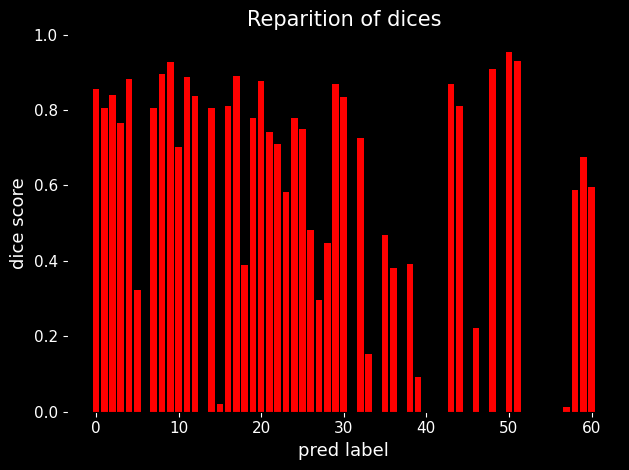

/tmp/ipykernel_639954/3257923404.py:28: RuntimeWarning: invalid value encountered in divide
  plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')


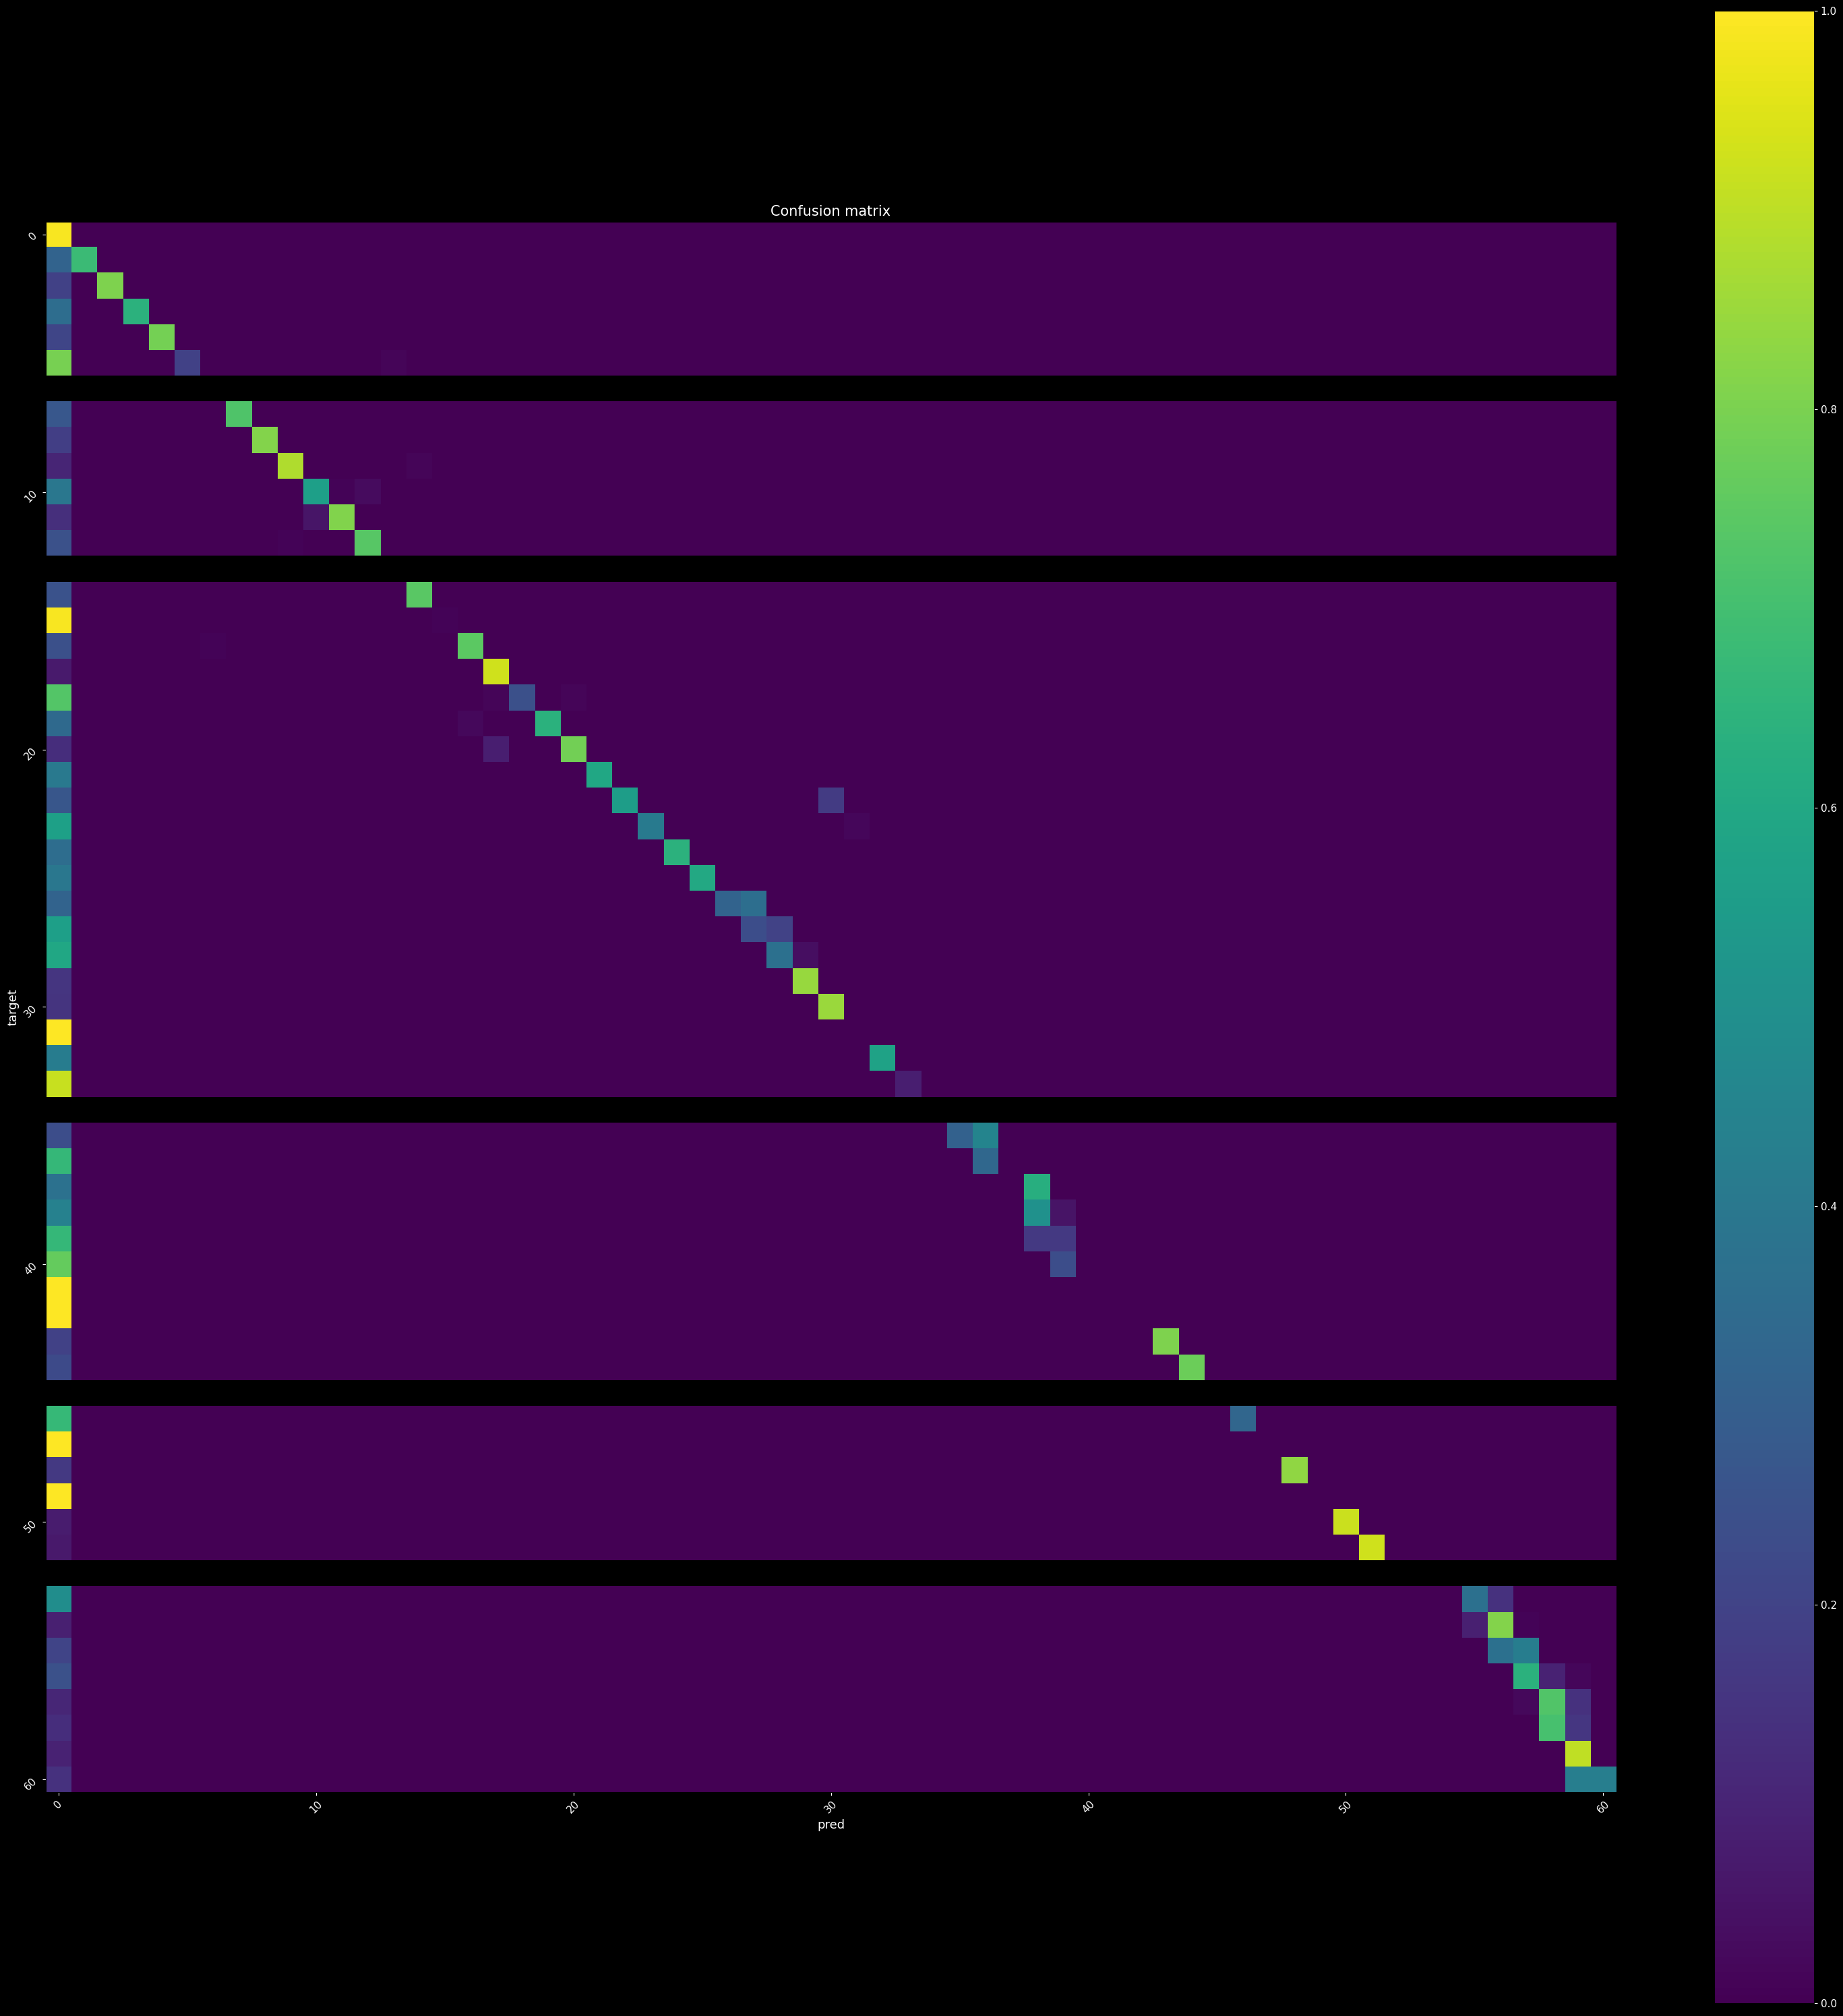

Row at index 1081
Image shape : (1, 247, 247, 257, 1) - Mask shape : (1, 247, 247, 257, 105) - Output shape : (1, 247, 247, 257)
0.8832340429465663
0.950145712866761
# wrong labels : [  0  11   1 485 237]


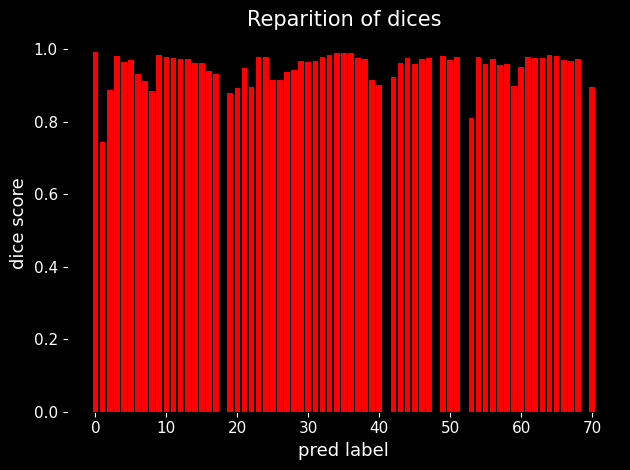

/tmp/ipykernel_639954/3257923404.py:28: RuntimeWarning: invalid value encountered in divide
  plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')


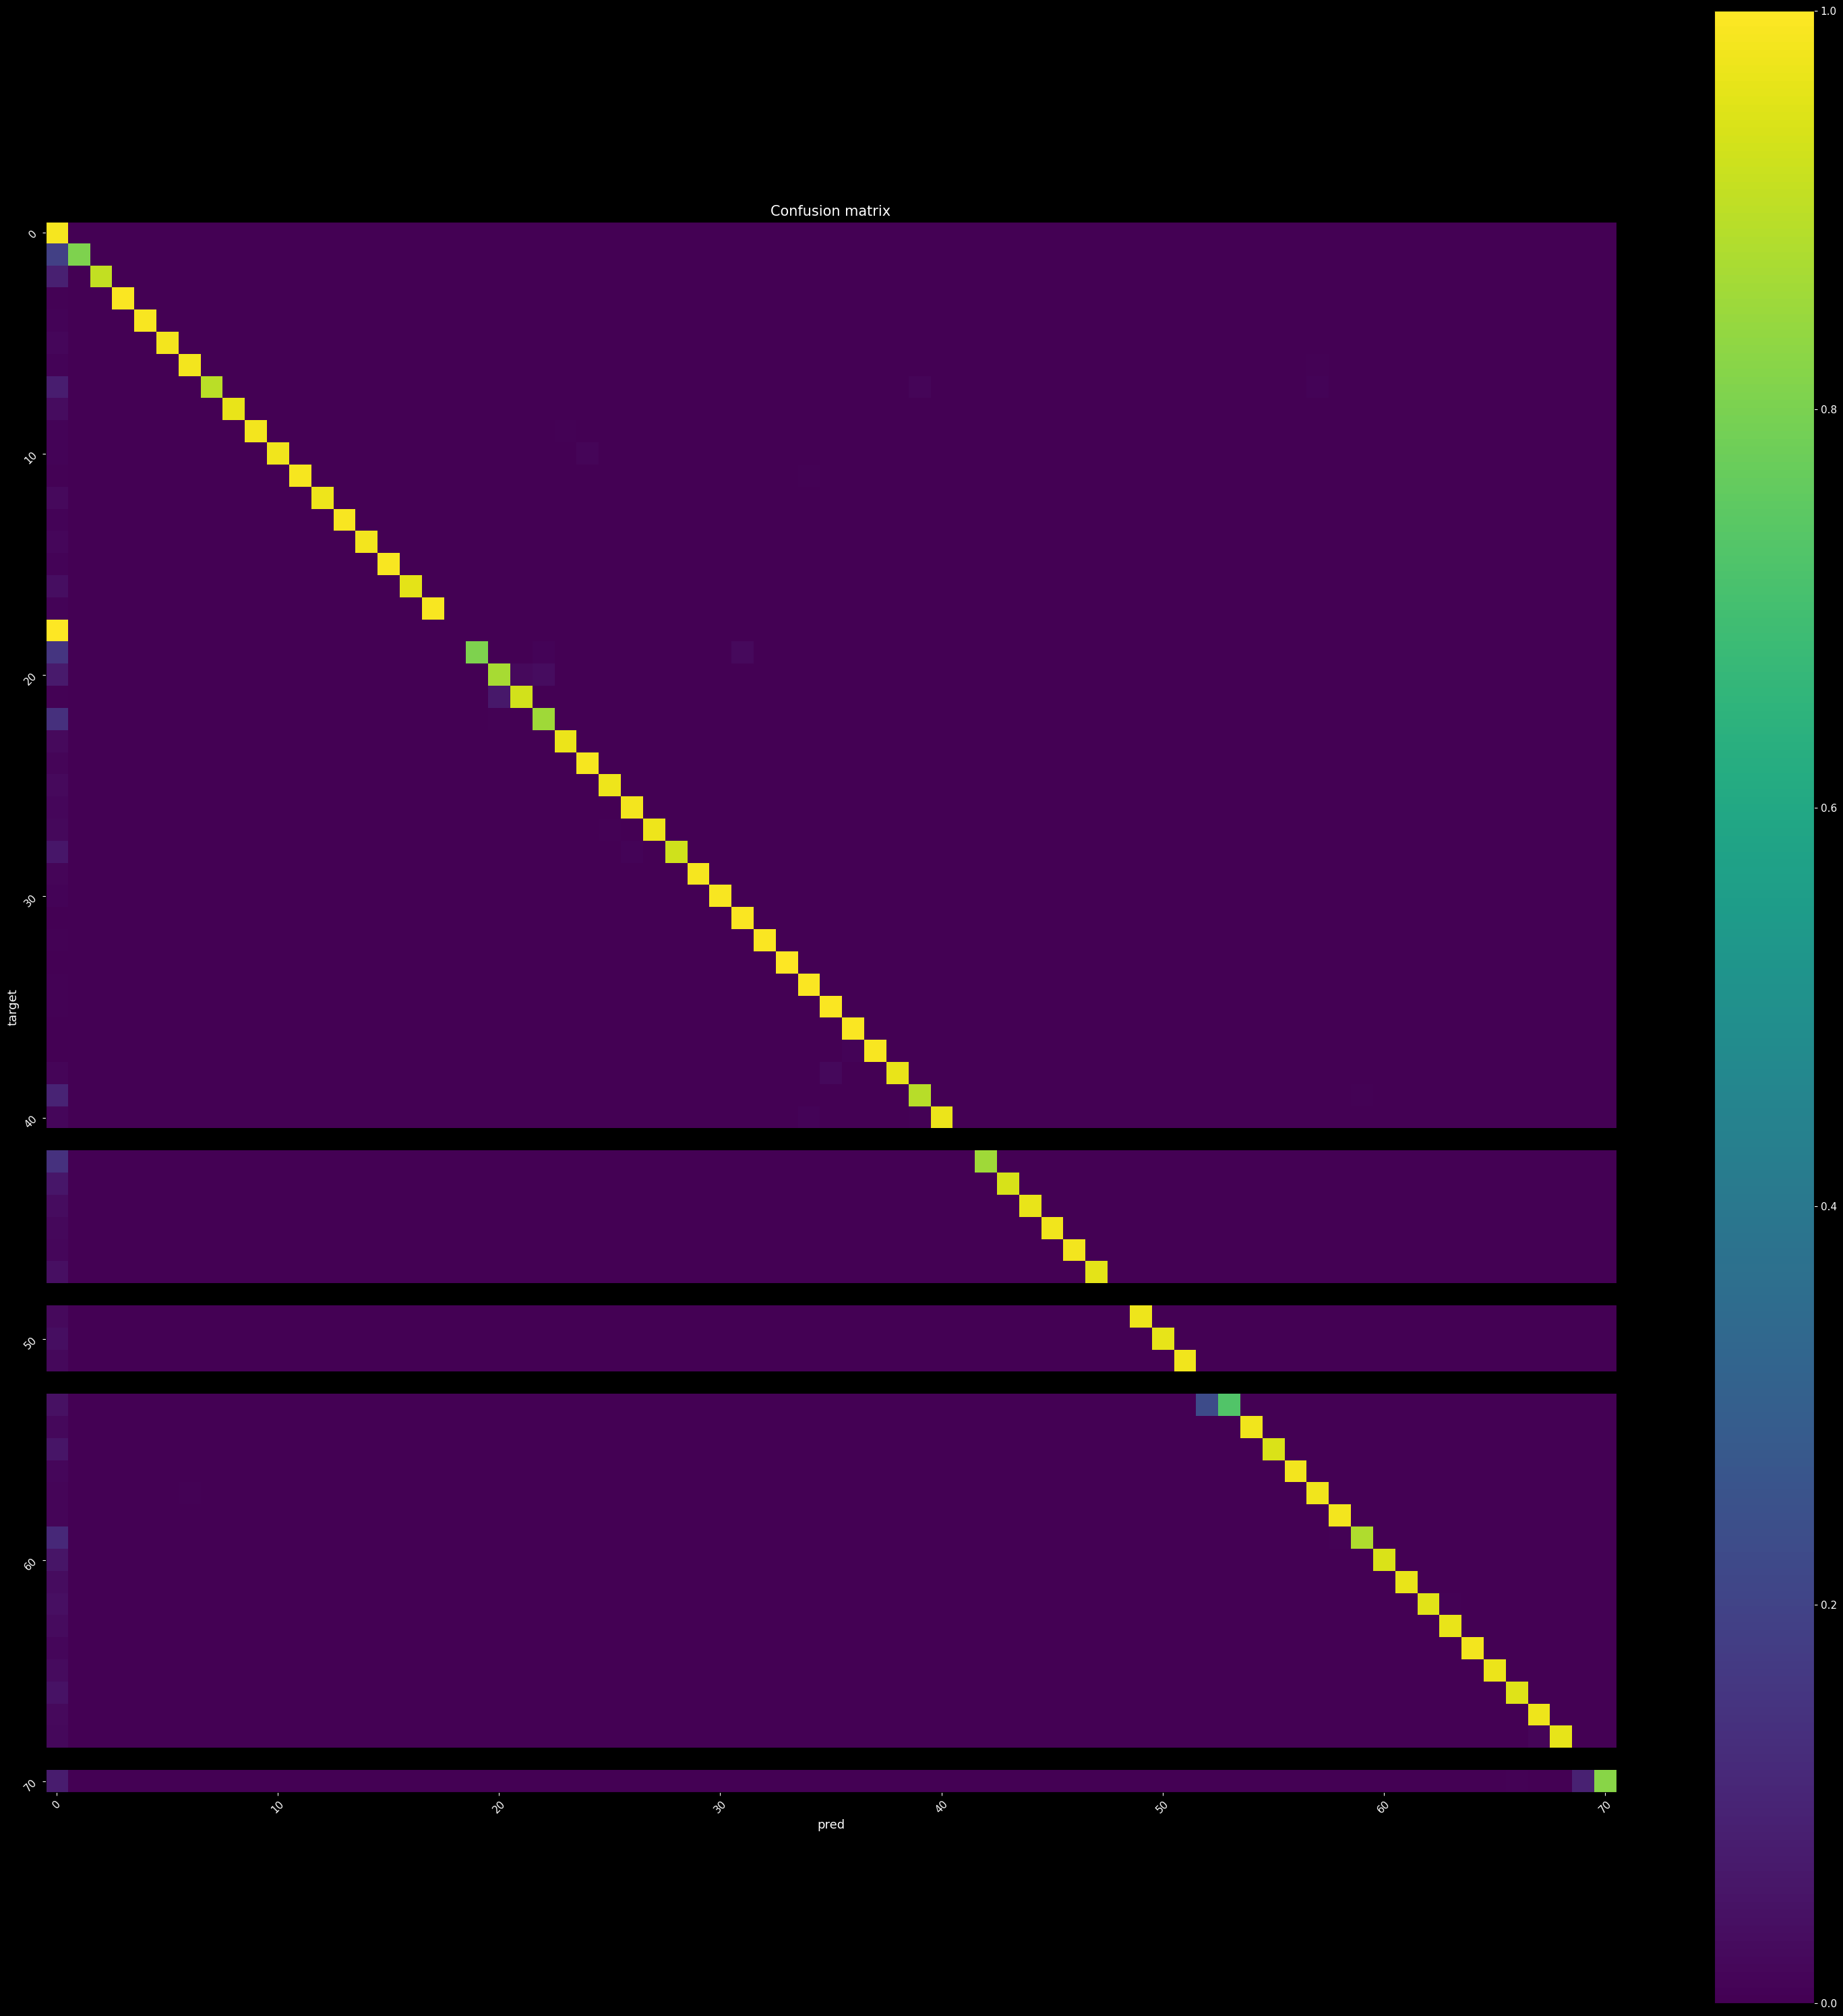

Row at index 1036
Image shape : (1, 256, 256, 267, 1) - Mask shape : (1, 256, 256, 267, 105) - Output shape : (1, 256, 256, 267)
0.7424010193426667
0.7939566456859075
# wrong labels : [ 0 61  4 26  5]


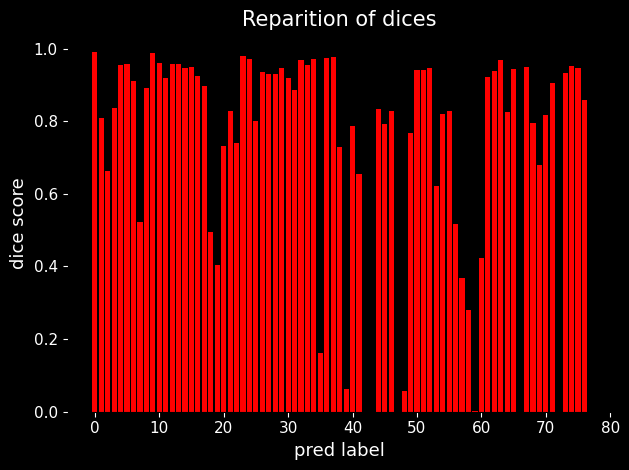

/tmp/ipykernel_639954/3257923404.py:28: RuntimeWarning: invalid value encountered in divide
  plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')


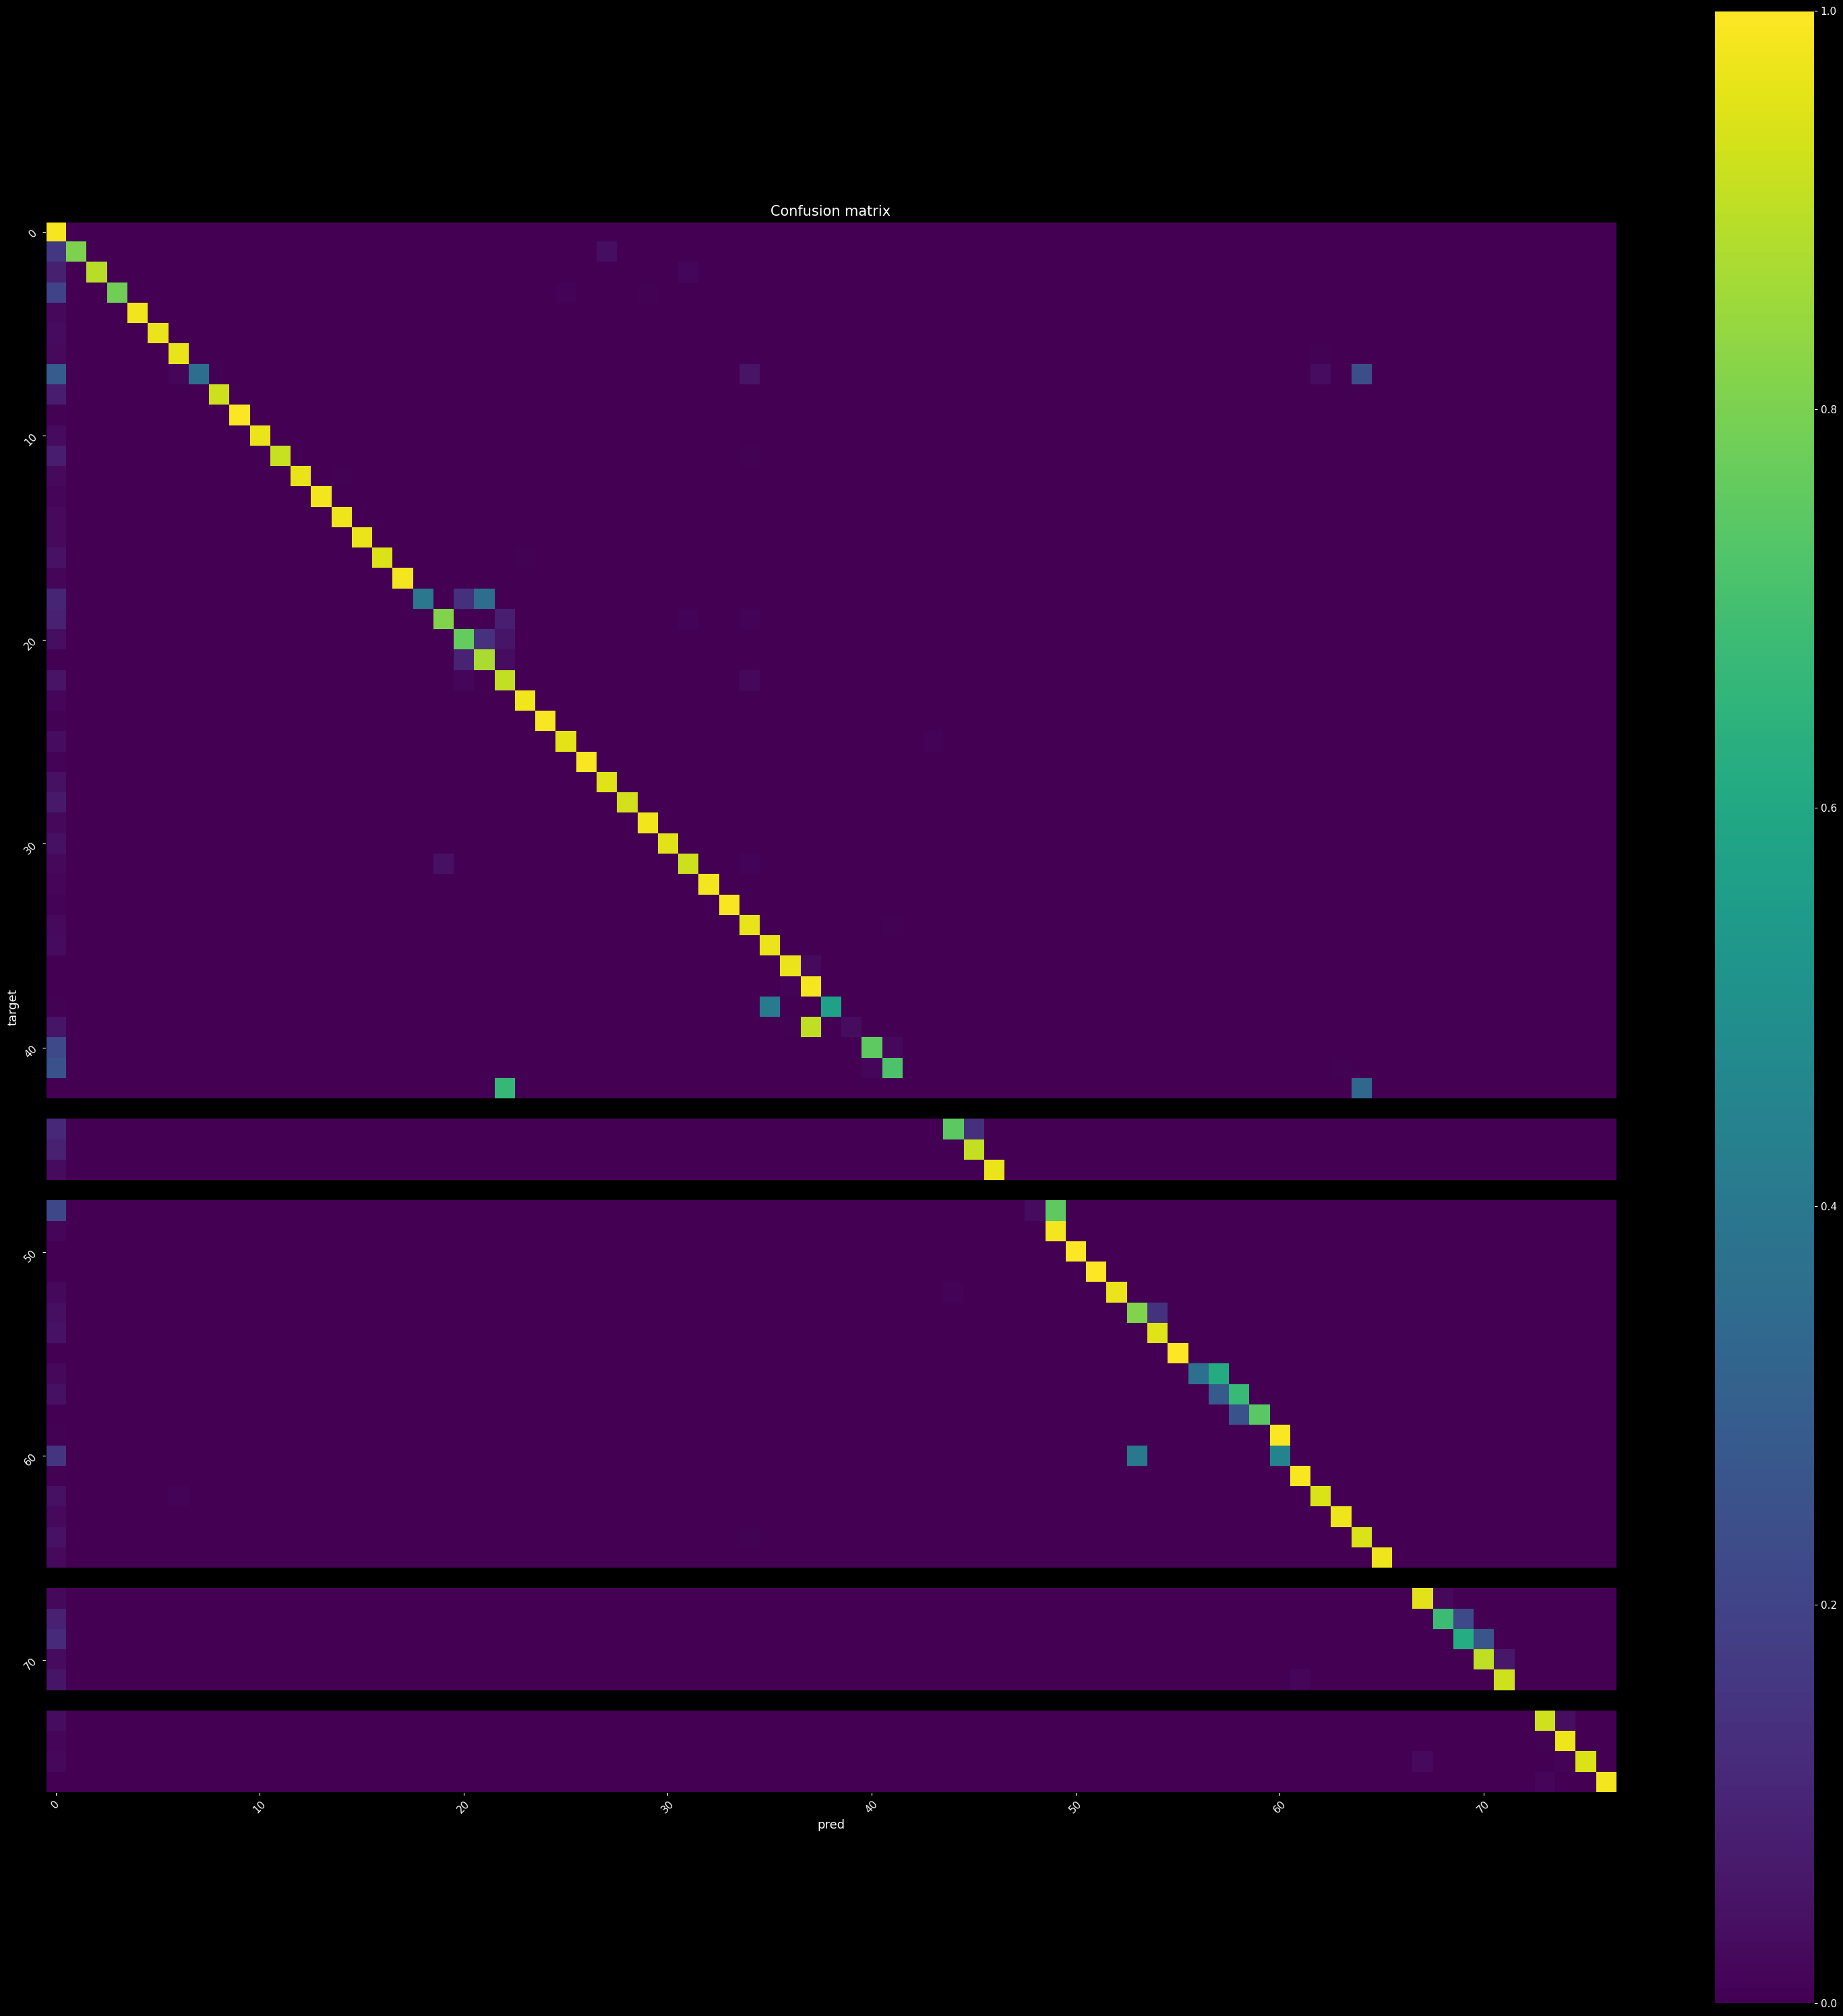

Row at index 427
Image shape : (1, 221, 221, 201, 1) - Mask shape : (1, 221, 221, 201, 105) - Output shape : (1, 221, 221, 201)
0.7988040851271516
0.8542765910387595
# wrong labels : [ 8  0  0 57  0]


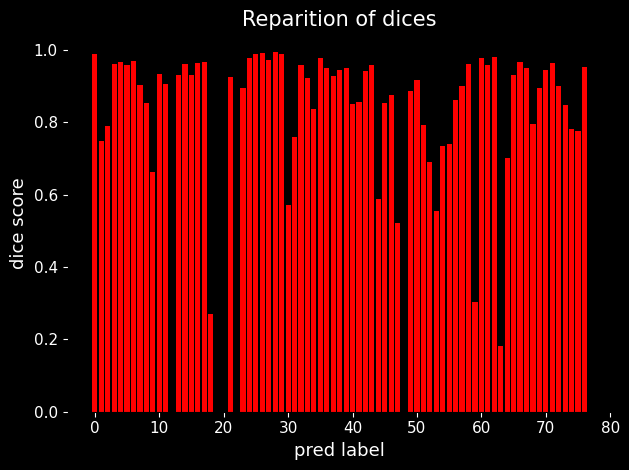

/tmp/ipykernel_639954/3257923404.py:28: RuntimeWarning: invalid value encountered in divide
  plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')


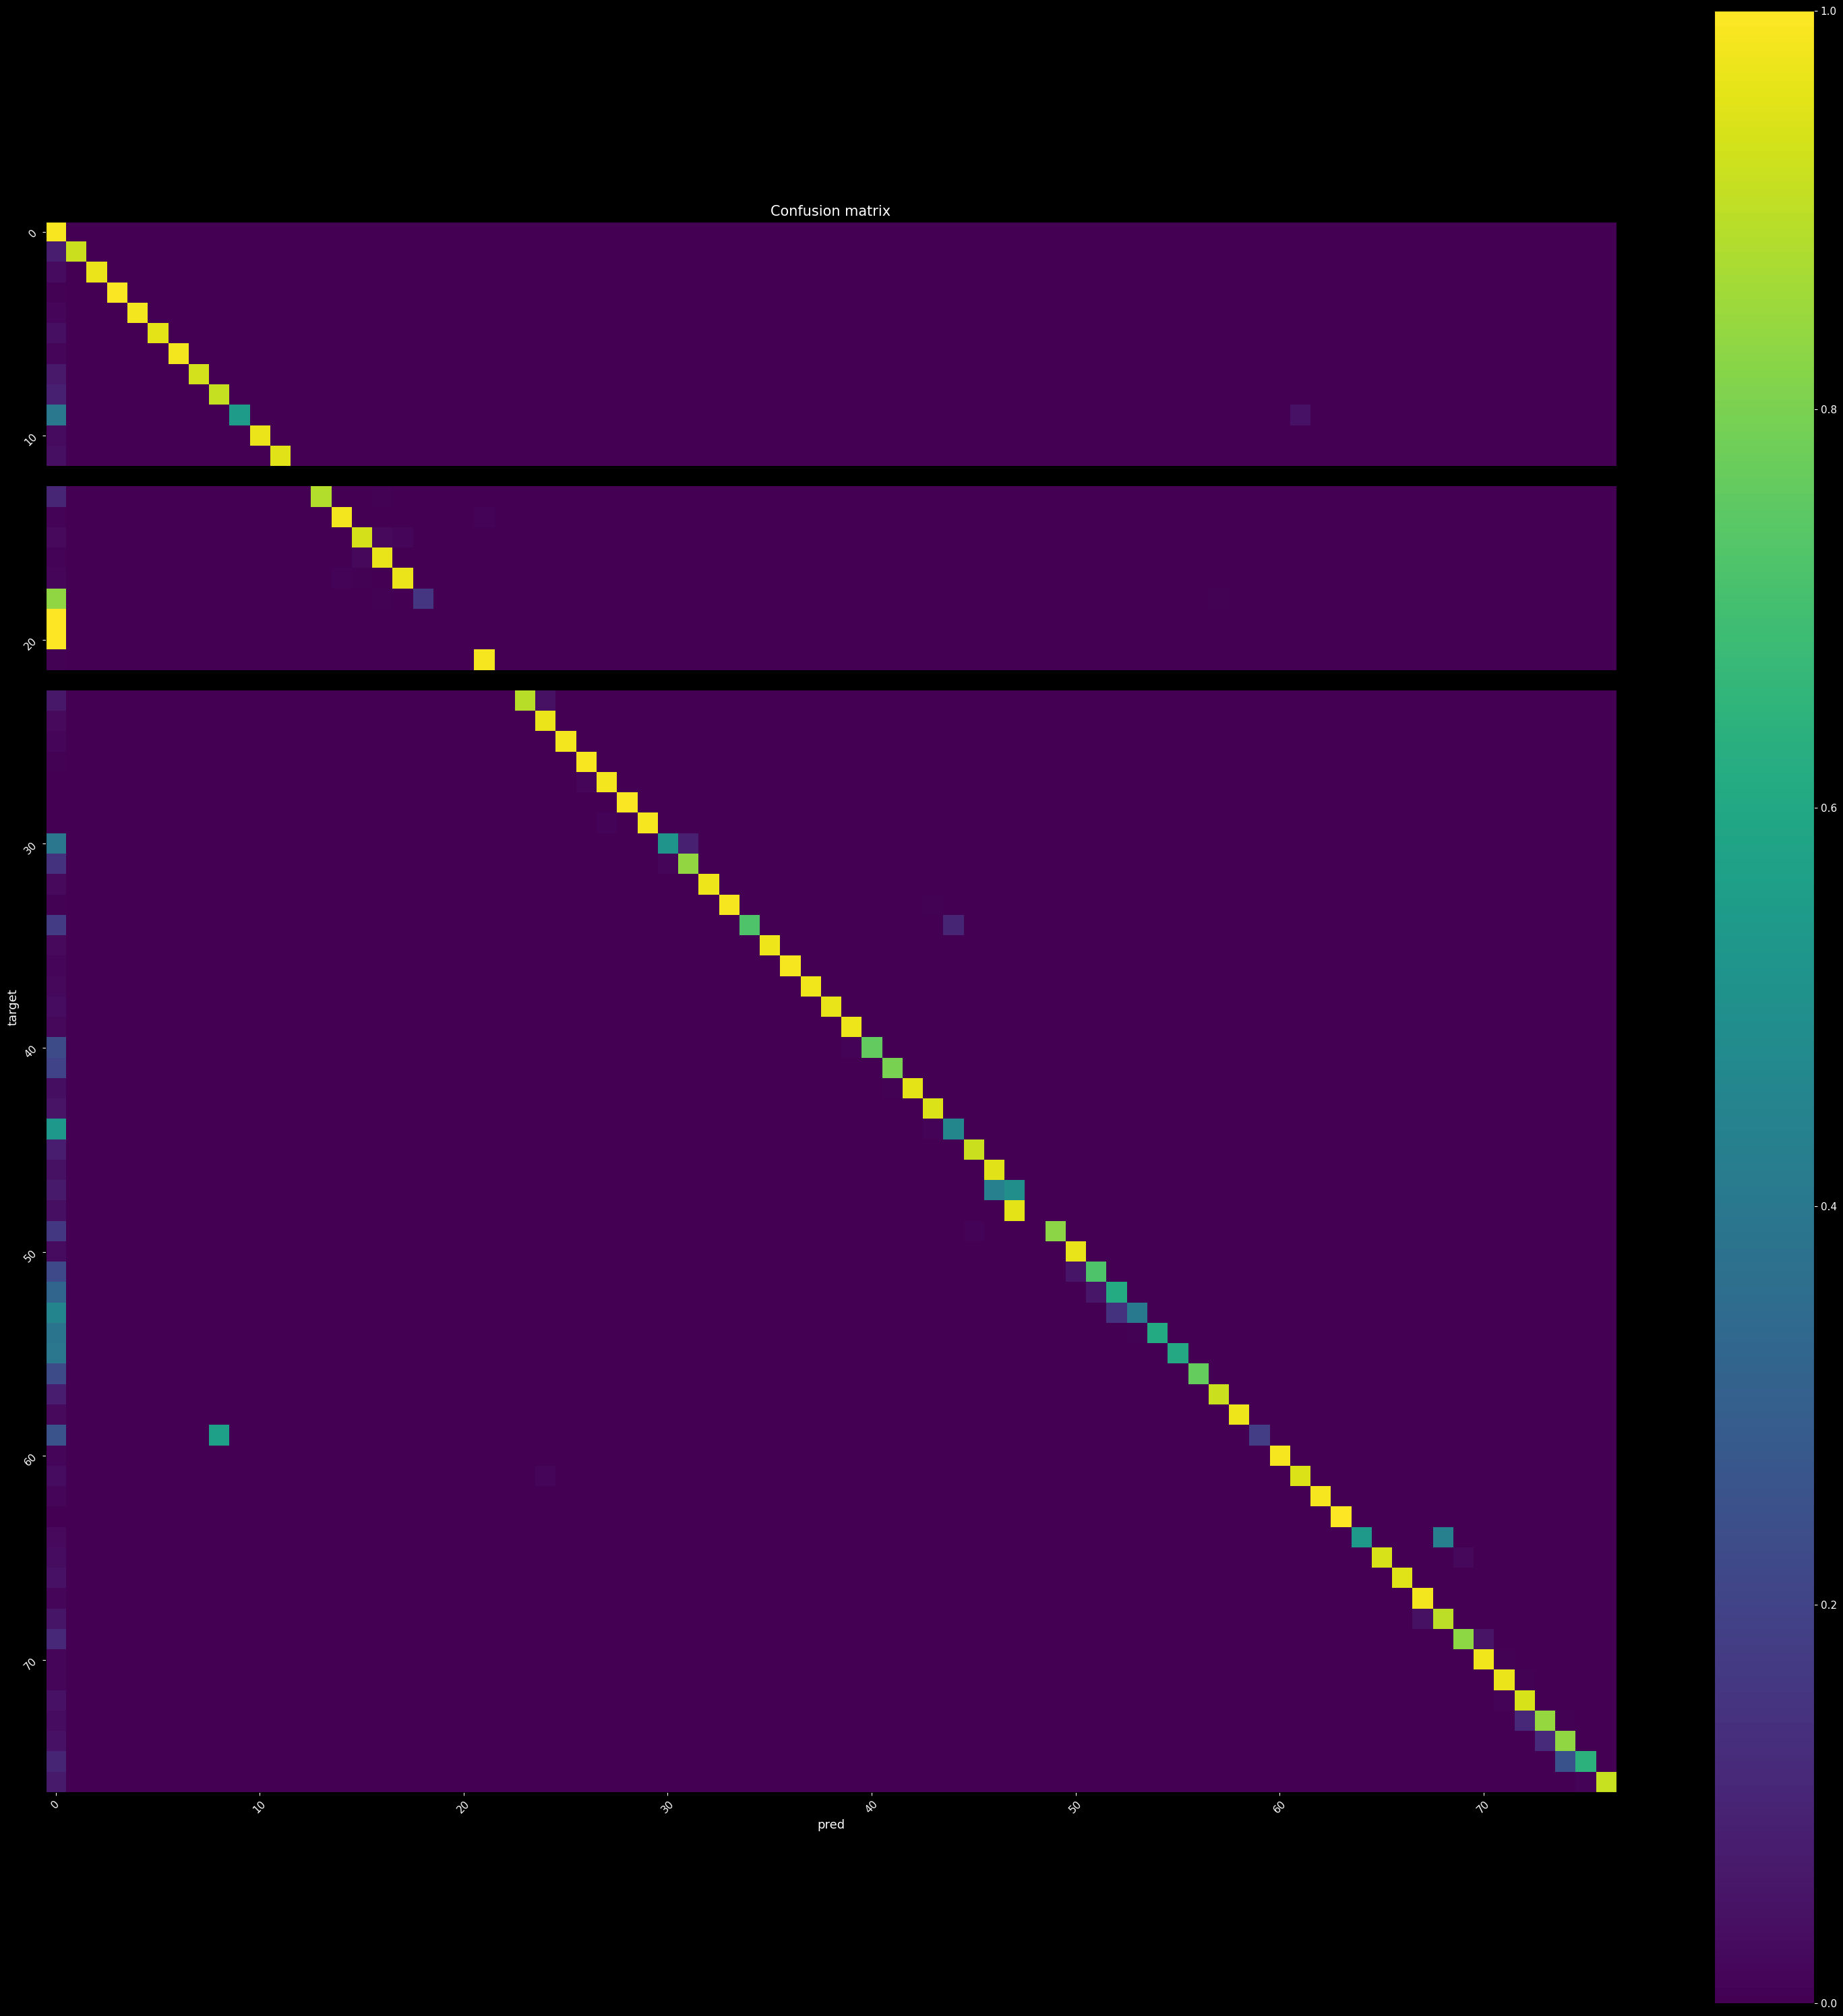

Row at index 764
Image shape : (1, 233, 233, 413, 1) - Mask shape : (1, 233, 233, 413, 105) - Output shape : (1, 233, 233, 413)
0.9088218270391623
0.9181911242251332
# wrong labels : [2]


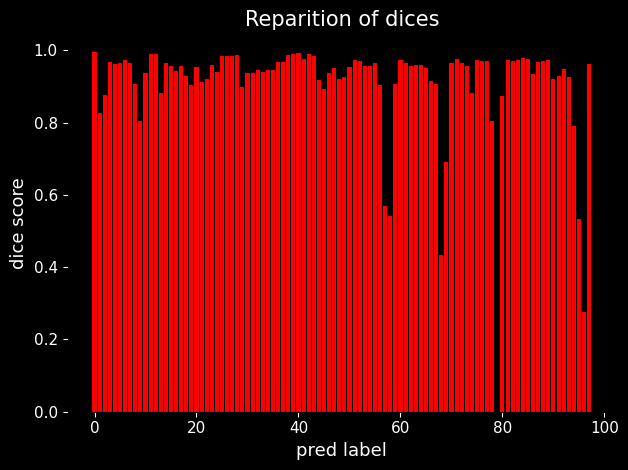

/tmp/ipykernel_639954/3257923404.py:28: RuntimeWarning: invalid value encountered in divide
  plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')


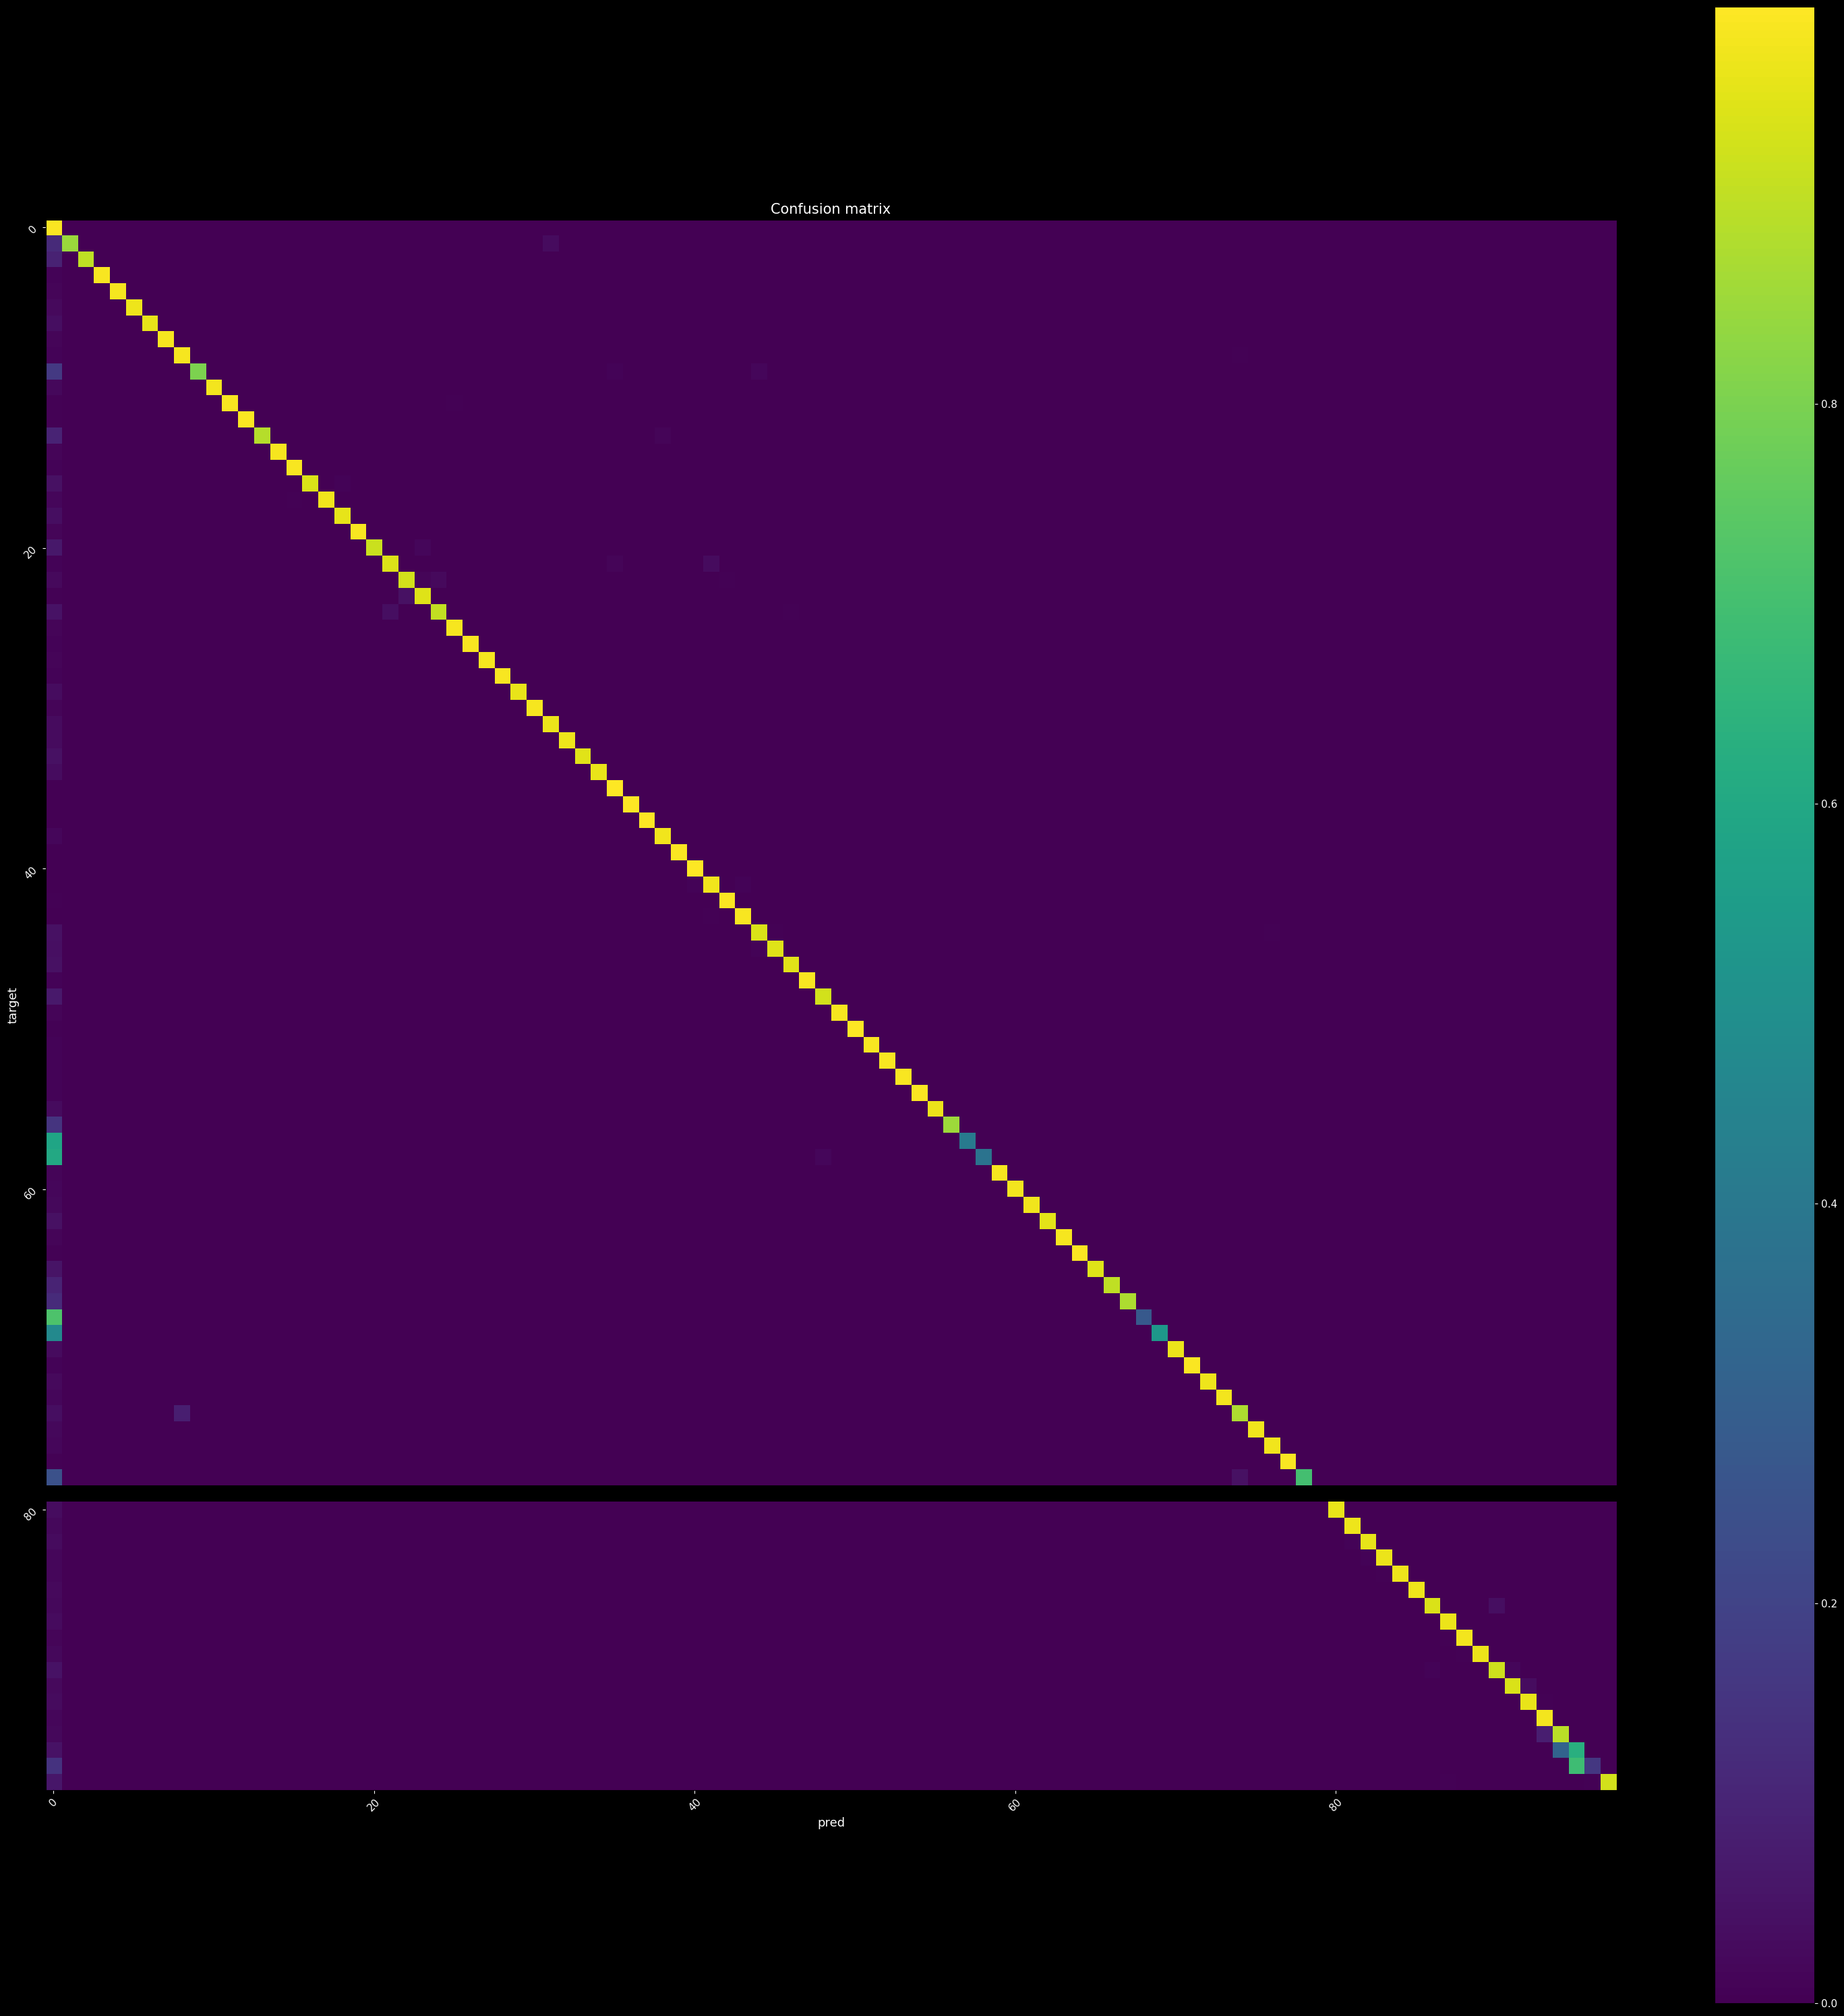

In [56]:
from sklearn.metrics import *

def evaluate(row, display = False):
    image, target = model.encode_data(row)
    image  = tf.expand_dims(image, axis = 0)
    target = tf.sparse.expand_dims(target, axis = 0)
    pred   = model.infer(image, 64, 16)
    
    print('Image shape : {} - Mask shape : {} - Output shape : {}'.format(image.shape, target.shape, pred.shape))
    
    with tf.device('cpu'):
        labels = tf.sparse.to_dense(target)
        labels = tf.argmax(labels, axis = -1).numpy()

    cm = multilabel_confusion_matrix(labels.reshape([-1]), pred.reshape([-1]))
    tn, fn, tp, fp = cm[:, 0, 0], cm[:, 1, 0], cm[:, 1, 1], cm[:, 0, 1]

    dices = 2 * tp / (2 * tp + fp + fn)
    #dices = dices[np.unique(labels)]

    print(np.mean(dices))
    print(np.mean(dices[dices > 0]))
    print("# wrong labels : {}".format(fp[dices == 0]))

    if display:
        plot(np.arange(len(dices)), dices, plot_type = 'bar', xlabel = 'pred label', ylabel = 'dice score', title = 'Reparition of dices')
        confusion = confusion_matrix(labels.reshape(-1), pred.reshape(-1))
        plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')
    
    return labels, pred, dices

model.max_size   = (None, None)
model.max_frames = -1

for idx, row in valid.iloc[:5].iterrows():
    print('Row at index {}'.format(idx))
    labels, pred, dices = evaluate(row, display = True)

In [54]:
cm = multilabel_confusion_matrix(labels.reshape([-1]), pred.reshape([-1]))
tn, fn, tp, fp = cm[:, 0, 0], cm[:, 1, 0], cm[:, 1, 1], cm[:, 0, 1]

print(np.sum(np.logical_and(tp == 0, fn == 0)))
print(np.sum(dices == 0))
print(fp.shape, dices.shape)


1
1
(98,) (98,)


In [55]:
print(fp[dices == 0])

[2]


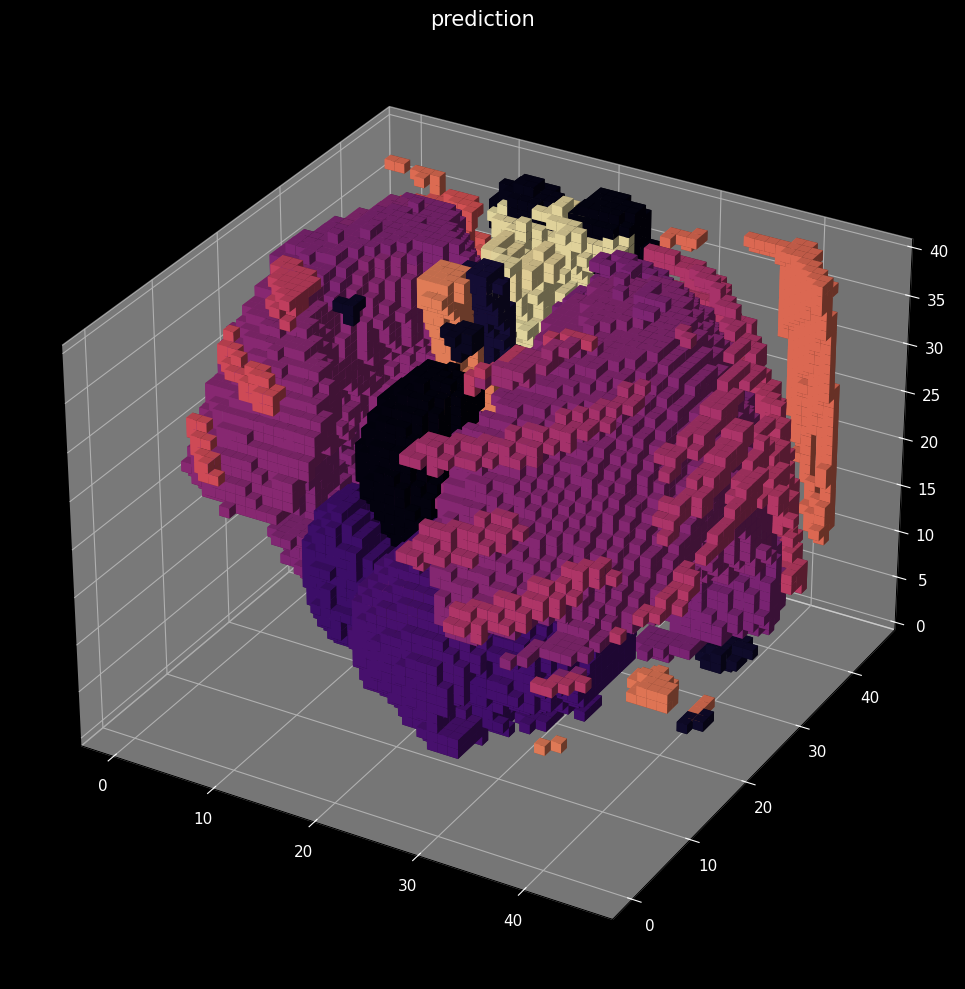

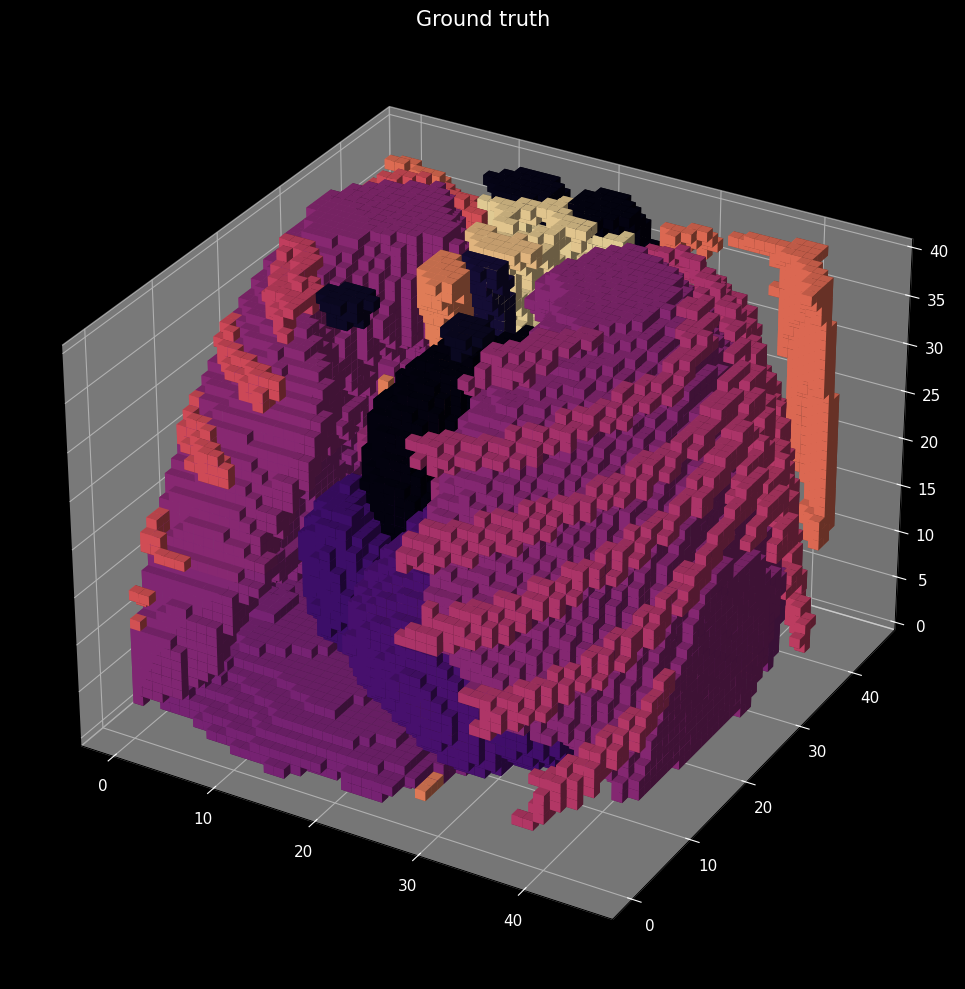

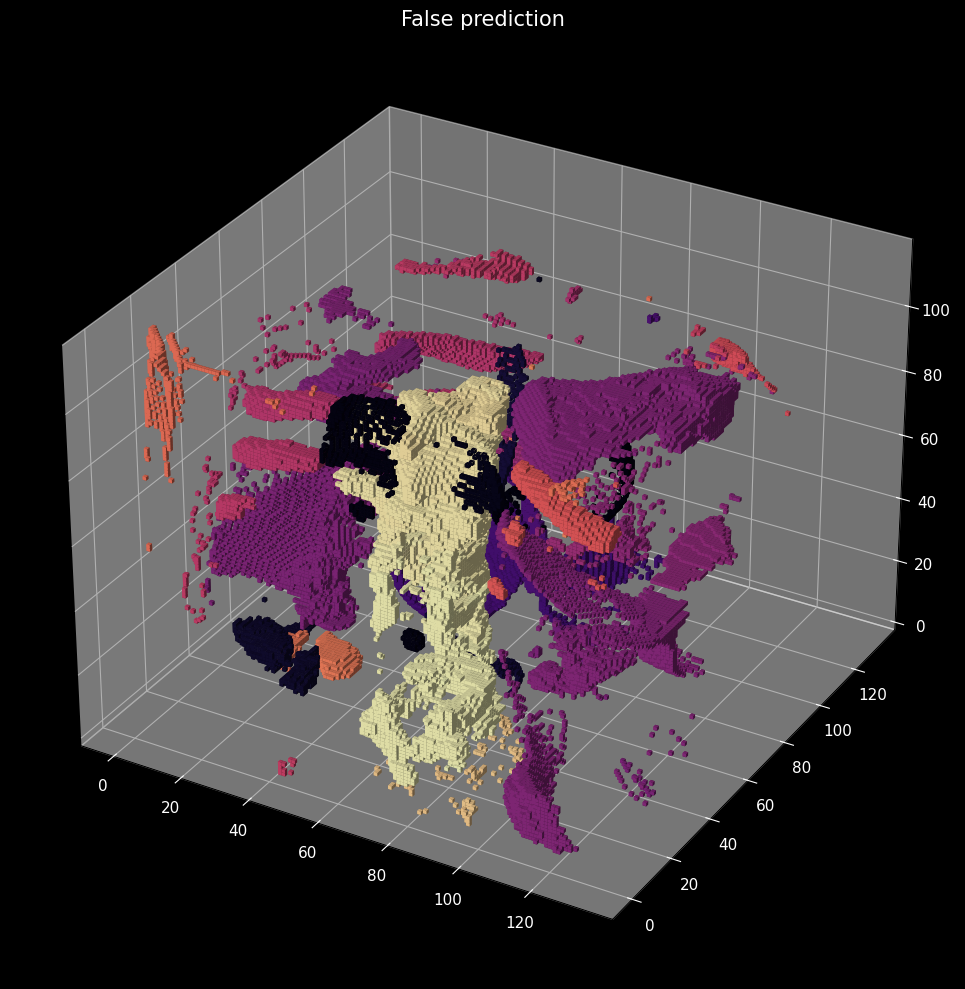

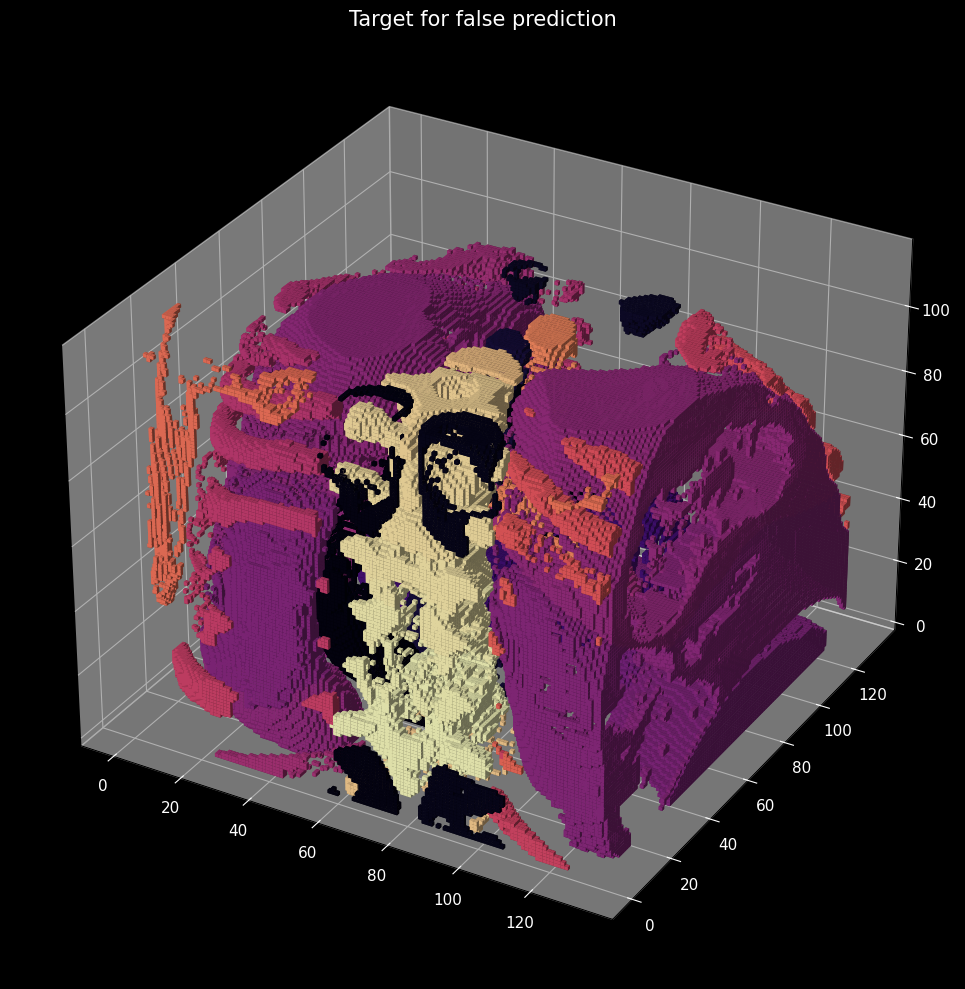

In [38]:
intersect = np.squeeze(pred == labels, axis = 0)

"""plot_multiple(
    target     = labels[0],
    prediction = pred[0],
    pred_error = {'volume' : pred[0] * np.logical_not(intersect), 'strides' : (1, 1, 1)},
    true_error = {'volume' : labels[0] * np.logical_not(intersect), 'strides' : (1, 1, 1)},

    ncols      = 2,
    strides    = (-3, -3, 3),
    plot_3d    = True,
    plot_type  = 'volume'
)
"""
plot_volume(pred[0], strides = (-3, -3, 3), title = 'prediction')
plot_volume(labels[0], strides = (-3, -3, 3), title = 'Ground truth')
plot_volume(pred[0] * np.logical_not(intersect), title = 'False prediction')
plot_volume(labels[0] * np.logical_not(intersect), title = 'Target for false prediction')

In [29]:
print(pred.shape)
print(labels.shape)

(1, 249, 188, 213)
(1, 249, 188, 213)


/tmp/ipykernel_639954/2613467823.py:4: RuntimeWarning: invalid value encountered in divide
  plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')


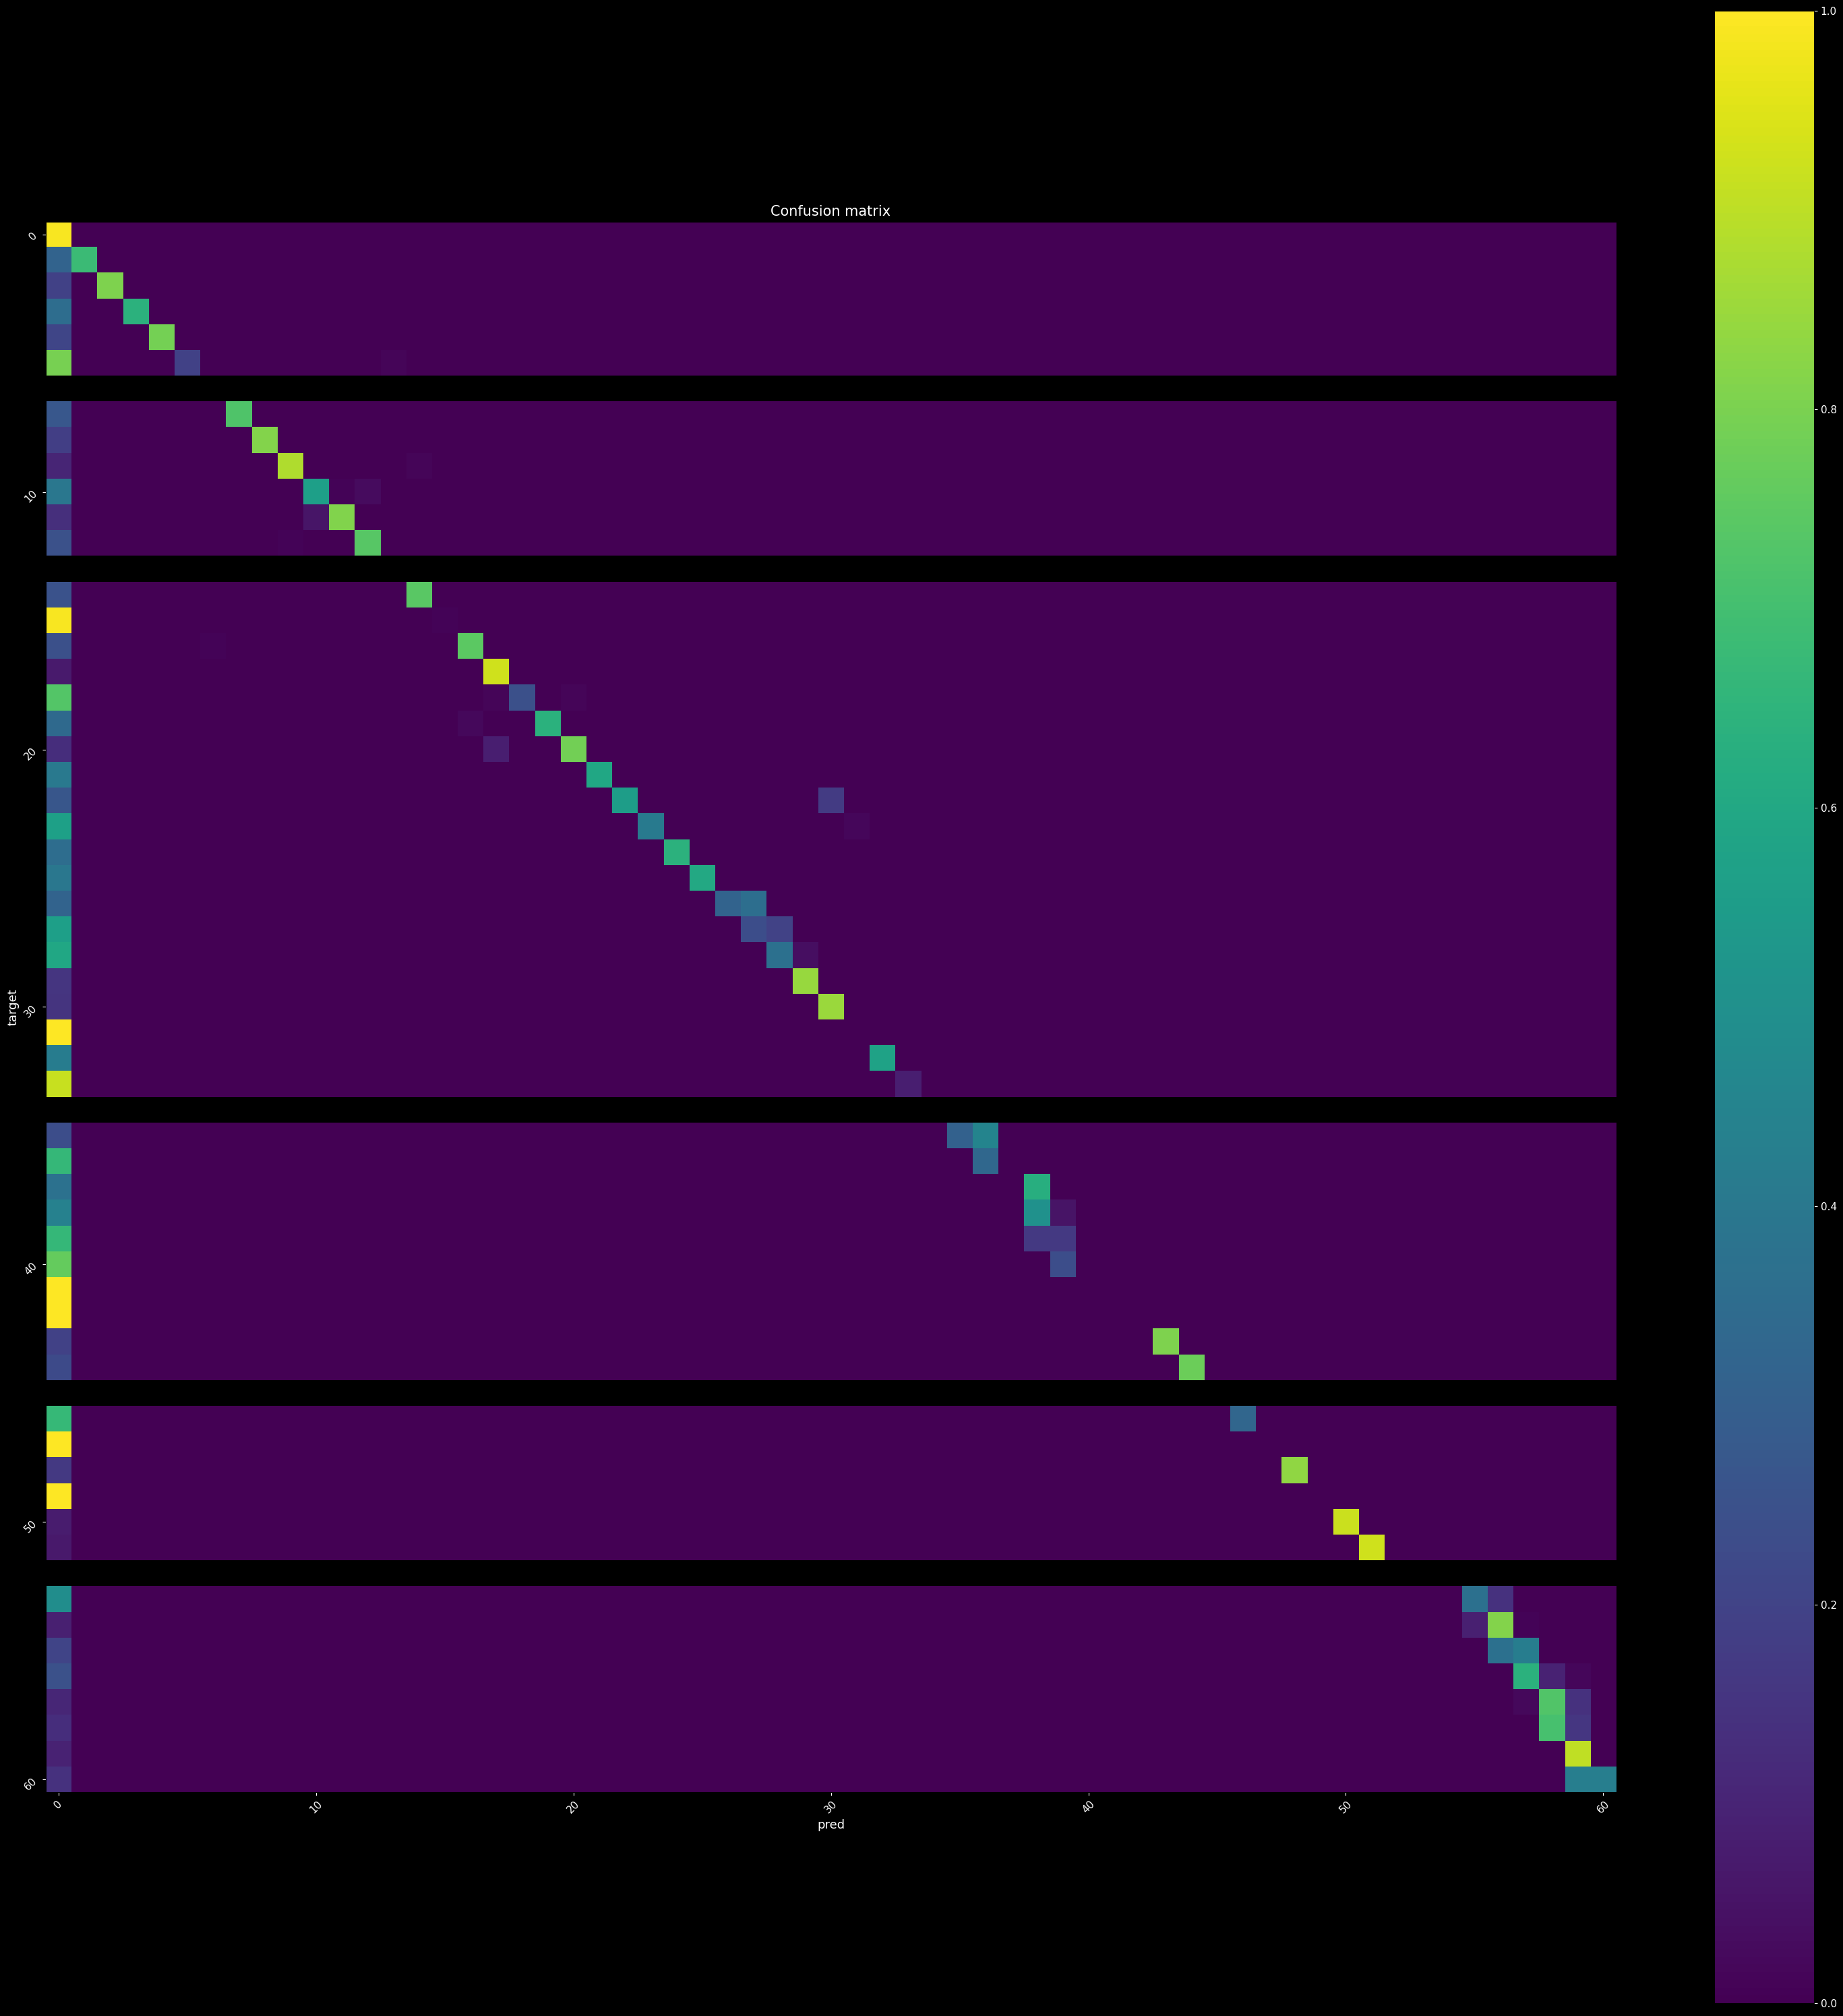

In [42]:
from utils import *

confusion = confusion_matrix(labels.reshape(-1), pred.reshape(-1))
plot_matrix(confusion / np.sum(confusion, axis = -1, keepdims = True), title = 'Confusion matrix', xlabel = 'pred', ylabel = 'target')

#plot_confusion_matrix(true = labels.reshape([-1]), pred = pred.reshape([-1]), norm = True)

## Prediction

In [9]:
class Test:
    @staticmethod
    def infer(self, data : tf.Tensor, win_len : tf.Tensor = -1, hop_len : tf.Tensor = -1):
        if self.is_3d:
            if win_len == -1: win_len = self.max_frames if self.max_frames is not None else tf.shape(images)[-2]
            if hop_len == -1: hop_len = win_len
        
        images = self.pad_to_multiple(data)
        if self.is_3d and win_len > 0 and win_len < images.shape[-2]:
            n_slices = tf.cast(tf.math.ceil((tf.shape(images)[-2] - win_len) / hop_len), tf.int32)
            
            pad = n_slices * hop_len + win_len - images.shape[-2]
            if pad > 0:
                n_slices += 1
                images = tf.pad(images, [(0, 0), (0, 0), (0, 0), (0, pad), (0, 0)])
            
            pred     = tf.TensorArray(
                dtype = tf.float32, size = n_slices
            )
            for i in tf.range(n_slices):
                out_i = self(
                    images[..., i * hop_len : i * hop_len + win_len, :], training = False
                )
                pred = pred.write(i, tf.transpose(out_i, [3, 0, 1, 2, 4]))
            
            pred = tf.transpose(pred.concat(), [1, 2, 3, 0, 4])
            if pad > 0: pred = pred[..., : - pad, :]
        else:
            pred = self(images, training = False)
        
        return pred[:, : data.shape[1], : data.shape[2]]

model.max_size   = (None, None)
model.max_frames = -1

row    = dataset.loc[0]

image  = tf.expand_dims(model.get_input(row), axis = 0)
output = model.get_output(row)

print('Image shape : {} - Mask shape : {}'.format(image.shape, output.shape))

with tf.device('cpu'):
    pred = Test.infer(model, image, 64)

print('Prediction shape : {}'.format(pred.shape))

Image shape : (1, 249, 188, 213, 1) - Mask shape : (249, 188, 213, 105)


2023-05-03 11:01:06.487040: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 4. But input(1) is a vector of size 5


InvalidArgumentError: {{function_node __wrapped__Transpose_device_/job:localhost/replica:0/task:0/device:CPU:0}} transpose expects a vector of size 4. But input(1) is a vector of size 5 [Op:Transpose]

In [5]:
from utils import is_equal

pred2 = model.infer(image, 64)

print(is_equal(np.argmax(pred, axis = -1), pred2.numpy()))

(False, 'Target shape (1, 249, 188, 213) != value shape (1, 249, 149, 213)')


In [80]:
#%timeit Test.infer(model, image, 64)

tf_infer = tf.function(Test.infer, reduce_retracing = True, experimental_follow_type_hints = True)
tf_infer(model, tf.pad(image, [(0, 0), (0,0), (0,0), (0,43), (0,0)]), 64)
%timeit tf_infer(model, image, 64)

256 Tensor("cond/Identity:0", shape=(), dtype=int32) Tensor("cond/Identity:0", shape=(), dtype=int32)
None Tensor("cond/Identity:0", shape=(), dtype=int32) Tensor("cond/Identity:0", shape=(), dtype=int32)
1.97 s ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


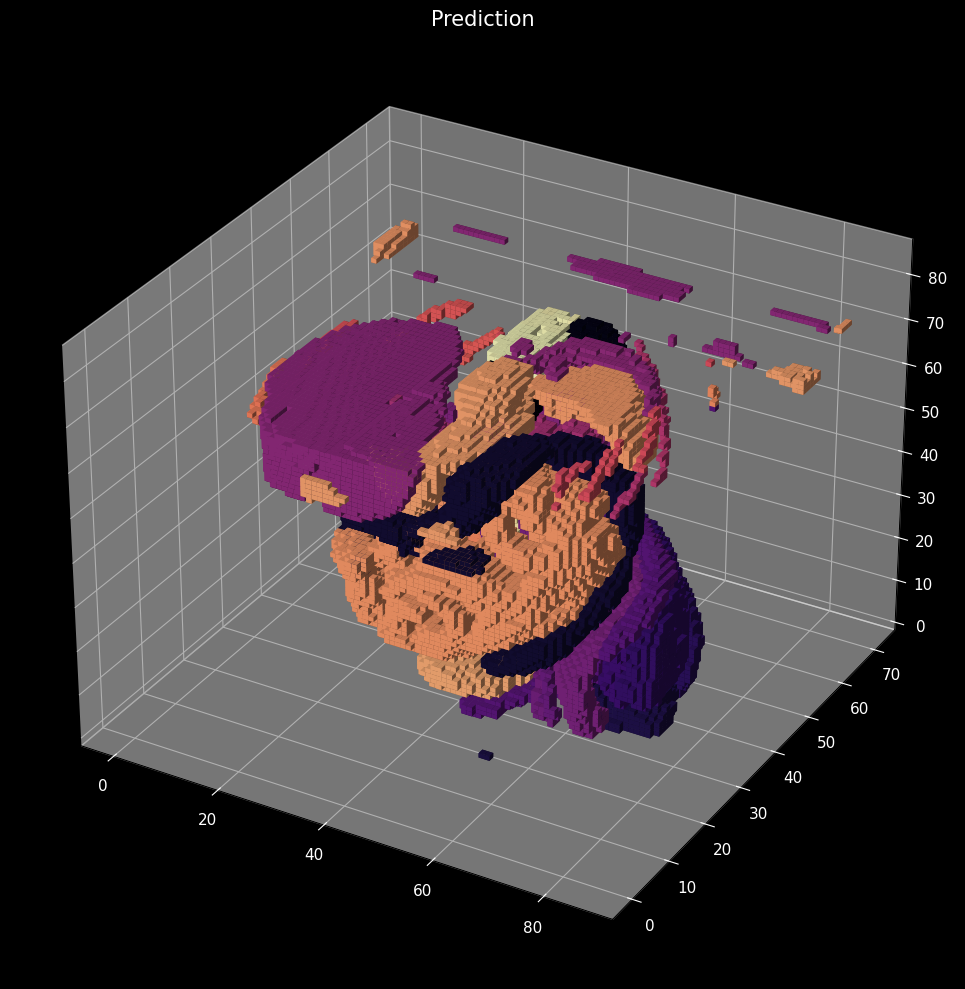

InvalidArgumentError: {{function_node __wrapped__SparseToDense_device_/job:localhost/replica:0/task:0/device:GPU:0}} indices[61843] is repeated.
	 [[{{node SparseToDense}}]] [Op:SparseToDense]

In [56]:
organs      = model.labels
show_organs = [i for i, o in enumerate(organs) if (o) and ('rib' in o or 'vertebr' in o or 'right' not in o)]

sx, sy, sz = -3, -3, 3

#plot_multiple(
#    prediction = pred[0], target = output, plot_type = 'voxels', plot_3d = True, use_subplots = True,
#    labels_to_show = show_organs, strides = (sx, sy, sz), size = 10, filename = 'prediction_test.png', show = True
#)
plot_volume(
    pred[0], labels_to_show = show_organs, strides = (sx, sy, sz), title = 'Prediction',
    filename = 'test_prediction.png', show = True
)
plot_volume(
    output, labels_to_show = show_organs, strides = (sx, sy, sz), title = 'Ground truth',
    filename = 'test_target.png', show = True
)

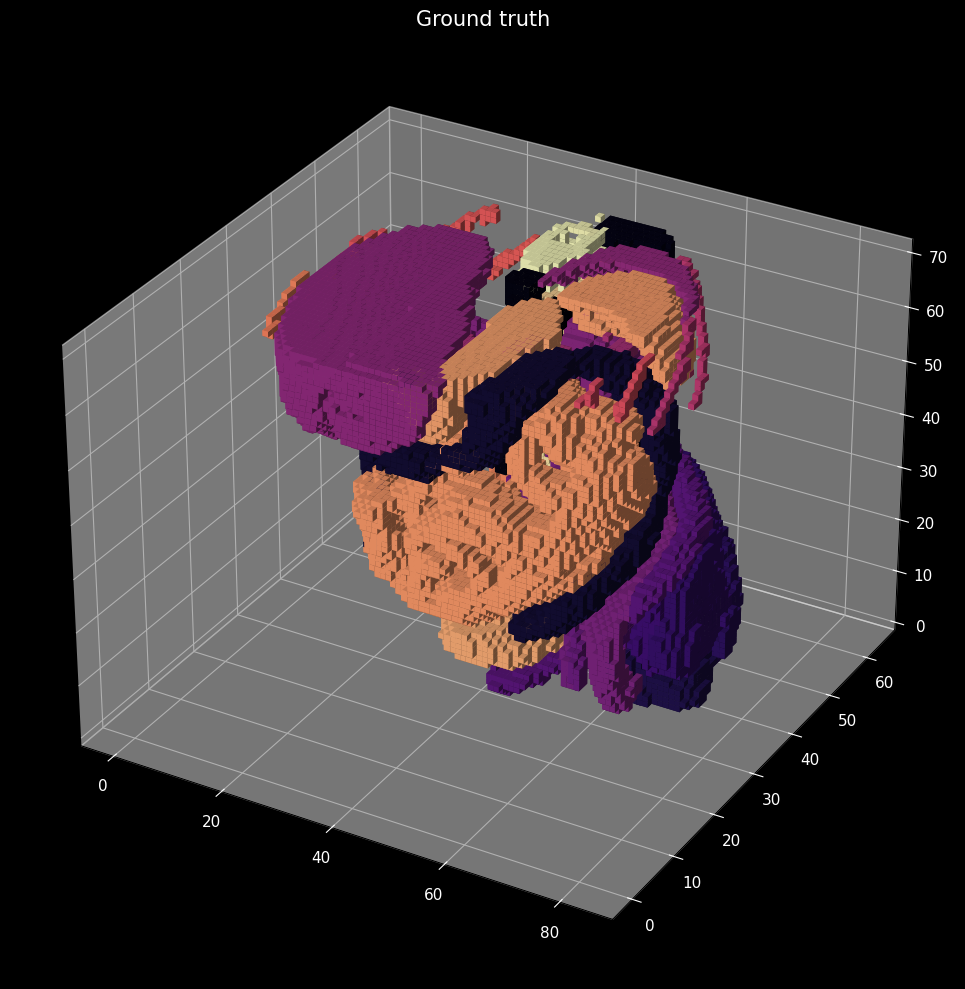

In [49]:
with tf.device('cpu'):
    out = np.argmax(tf.sparse.to_dense(output).numpy(), axis = -1)

plot_volume(
    out, labels_to_show = show_organs, strides = (sx, sy, sz), title = 'Ground truth',
    filename = 'test_target.png', show = True
)

## Prediction with dataset

In [51]:
model.load_checkpoint(checkpoint = model.save_dir + '/ckpt-85')

In [ ]:
if 'highres' in model_name:
    image_size   = 512 - 64
    model.max_size     = (image_size, image_size)
    model.max_frames   = 32
elif 'lowres' in model_name:
    image_size   = 128
    model.max_size     = (image_size, image_size)
    model.max_frames   = 128
else:
    image_size   = 256
    model.max_size     = (image_size, image_size)
    model.max_frames   = 32

model.pad_value = 0.
print(model.max_size, model.max_frames)
config = model.get_dataset_config(is_validation = False, batch_size = 0, shuffle_size = 0)

set_level('debug', 'datasets')

ds = prepare_dataset(train.iloc[:1], ** config)

set_level('info', 'datasets')

model.get_loss().skip_empty_frames.assign(True)
model.get_loss().skip_empty_labels.assign(True)

for inp, out in ds:
    print('Input shape : {} - output shape : {}'.format(inp.shape, out.shape))
    #plot_mask(inp[..., 0], out, n = 4)
    pred = model(tf.expand_dims(inp, axis = 0))[0]
    intersect = tf.cast(out, tf.float32) * pred
    print(model.get_loss()(tf.sparse.expand_dims(out, 0), pred[tf.newaxis]))
    print(tf.sparse.reduce_sum(intersect) / len(intersect.indices))
    print(intersect)
    plot_mask(inp[..., 0], tf.cast(pred > 0.01, tf.uint8), n = 4)
    
    

In [56]:
mask   = (pred.numpy() > 0.1).astype(np.uint8)
labels = np.argmax(mask[..., 1:], axis = -1) + 1
voxels = np.any(mask[..., 1:], axis = -1)

organs = model.labels

show_organs = [o for o in organs if (o is not None) and ('rib' in o or 'vertebr' in o )]

skip_indexes = [i for i, organ in enumerate(organs) if organ not in show_organs]

#voxels[np.any(mask[..., skip_indexes], axis = -1)] = 0
#labels[np.any(mask[..., skip_indexes], axis = -1)] = 0


In [57]:
print(np.any(mask, axis = -1).sum())
print(skip_indexes)
print(voxels.sum())

2097152
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 73, 74, 75, 76, 77, 78, 79, 80]
428643


In [ ]:
from utils import plot_utils

importlib.reload(plot_utils)

import matplotlib.pyplot as plt

from loggers import set_level

set_level('debug', 'utils.plot_utils')

def add_color_axis(labels, cmap = None):
    mapper = plt.cm.ScalarMappable(cmap = cmap)
    return np.reshape(mapper.to_rgba(np.reshape(labels, [-1]).tolist()), list(labels.shape) + [4])

sx, sy, sz = -3, 3, 1

plot_utils.plot(
    voxels[::sy, ::sx, ::sz].astype(bool),
    figsize    = (10, 10),
    facecolors = add_color_axis(labels[::sy, ::sx, ::sz], cmap = 'magma'),
    plot_type  = 'voxels',
    color      = None,
    is_3d      = True,
    with_legend = True,
    with_colorbar = True
)

## Tests

### Test dataset performances

In [ ]:
from loggers import set_level

model.max_frames = 32
model.max_size   = (None, None)

set_level('debug', 'datasets')

config = model.get_dataset_config(is_validation = True, batch_size = 1, cache = False, prefetch = False, shuffle_size = 0)

ds_train = prepare_dataset(valid, ** config)

set_level('info', 'datasets')

test_dataset_time(ds_train, steps = 100)

In [6]:
from tqdm import tqdm

for idx, row in tqdm(valid.iterrows(), total = len(valid)):
    inp, out = model.encode_data(row)
    if not model.filter_data(inp, out):
        print(inp.shape, out.dense_shape)
        print(row)

645it [09:24,  1.77it/s]

(288, 176, 32, 1) tf.Tensor([288 176  32 105], shape=(4,), dtype=int64)
subject_id                                                  s0437
thickness                                                      -1
images          /storage/Totalsegmentator_dataset/s0437/ct.nii.gz
segmentation    /storage/Totalsegmentator_dataset/s0437/masks.npz
label           [adrenal_gland_left, adrenal_gland_right, aort...
start_frame                                                     0
end_frame                                                      32
id                                                          s0437
Name: 7290, dtype: object


647it [09:26,  1.57it/s]

(288, 176, 32, 1) tf.Tensor([288 176  32 105], shape=(4,), dtype=int64)
subject_id                                                  s0437
thickness                                                      -1
images          /storage/Totalsegmentator_dataset/s0437/ct.nii.gz
segmentation    /storage/Totalsegmentator_dataset/s0437/masks.npz
label           [adrenal_gland_left, adrenal_gland_right, aort...
start_frame                                                    32
end_frame                                                      64
id                                                          s0437
Name: 7292, dtype: object


654it [09:31,  1.42it/s]

(288, 176, 32, 1) tf.Tensor([288 176  32 105], shape=(4,), dtype=int64)
subject_id                                                  s0437
thickness                                                      -1
images          /storage/Totalsegmentator_dataset/s0437/ct.nii.gz
segmentation    /storage/Totalsegmentator_dataset/s0437/masks.npz
label           [adrenal_gland_left, adrenal_gland_right, aort...
start_frame                                                   144
end_frame                                                     176
id                                                          s0437
Name: 7299, dtype: object


937it [14:24,  1.45it/s]

(272, 208, 32, 1) tf.Tensor([272 208  32 105], shape=(4,), dtype=int64)
subject_id                                                  s0651
thickness                                                      -1
images          /storage/Totalsegmentator_dataset/s0651/ct.nii.gz
segmentation    /storage/Totalsegmentator_dataset/s0651/masks.npz
label           [adrenal_gland_left, adrenal_gland_right, aort...
start_frame                                                   128
end_frame                                                     160
id                                                          s0651
Name: 9632, dtype: object


939it [14:25,  1.47it/s]

(272, 208, 32, 1) tf.Tensor([272 208  32 105], shape=(4,), dtype=int64)
subject_id                                                  s0651
thickness                                                      -1
images          /storage/Totalsegmentator_dataset/s0651/ct.nii.gz
segmentation    /storage/Totalsegmentator_dataset/s0651/masks.npz
label           [adrenal_gland_left, adrenal_gland_right, aort...
start_frame                                                   160
end_frame                                                     192
id                                                          s0651
Name: 9634, dtype: object


945it [14:29,  1.48it/s]

(272, 208, 32, 1) tf.Tensor([272 208  32 105], shape=(4,), dtype=int64)
subject_id                                                  s0651
thickness                                                      -1
images          /storage/Totalsegmentator_dataset/s0651/ct.nii.gz
segmentation    /storage/Totalsegmentator_dataset/s0651/masks.npz
label           [adrenal_gland_left, adrenal_gland_right, aort...
start_frame                                                   256
end_frame                                                     288
id                                                          s0651
Name: 9640, dtype: object


1464it [22:11,  1.95s/it]

(320, 320, 32, 1) tf.Tensor([320 320  32 105], shape=(4,), dtype=int64)
subject_id                                                  s1171
thickness                                                      -1
images          /storage/Totalsegmentator_dataset/s1171/ct.nii.gz
segmentation    /storage/Totalsegmentator_dataset/s1171/masks.npz
label           [adrenal_gland_left, adrenal_gland_right, aort...
start_frame                                                   208
end_frame                                                     240
id                                                          s1171
Name: 15005, dtype: object


1474it [22:31,  1.96s/it]

(320, 320, 32, 1) tf.Tensor([320 320  32 105], shape=(4,), dtype=int64)
subject_id                                                  s1171
thickness                                                      -1
images          /storage/Totalsegmentator_dataset/s1171/ct.nii.gz
segmentation    /storage/Totalsegmentator_dataset/s1171/masks.npz
label           [adrenal_gland_left, adrenal_gland_right, aort...
start_frame                                                   368
end_frame                                                     400
id                                                          s1171
Name: 15015, dtype: object


2066it [33:07,  1.04it/s]


### Dataset visualization

(256, 256) 32
Original dataset : <TensorSliceDataset element_spec={'subject_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'thickness': TensorSpec(shape=(), dtype=tf.int32, name=None), 'images': TensorSpec(shape=(), dtype=tf.string, name=None), 'segmentation': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(104,), dtype=tf.string, name=None)}>
- Dataset after encoding : <ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), SparseTensorSpec(TensorShape([None, None, None, None]), tf.uint8))>
- Dataset after augmentation : <ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), SparseTensorSpec(TensorShape([None, None, None, None]), tf.uint8))>
Input shape : (256, 256, 32, 1) - output shape : (256, 256, 32, 105)


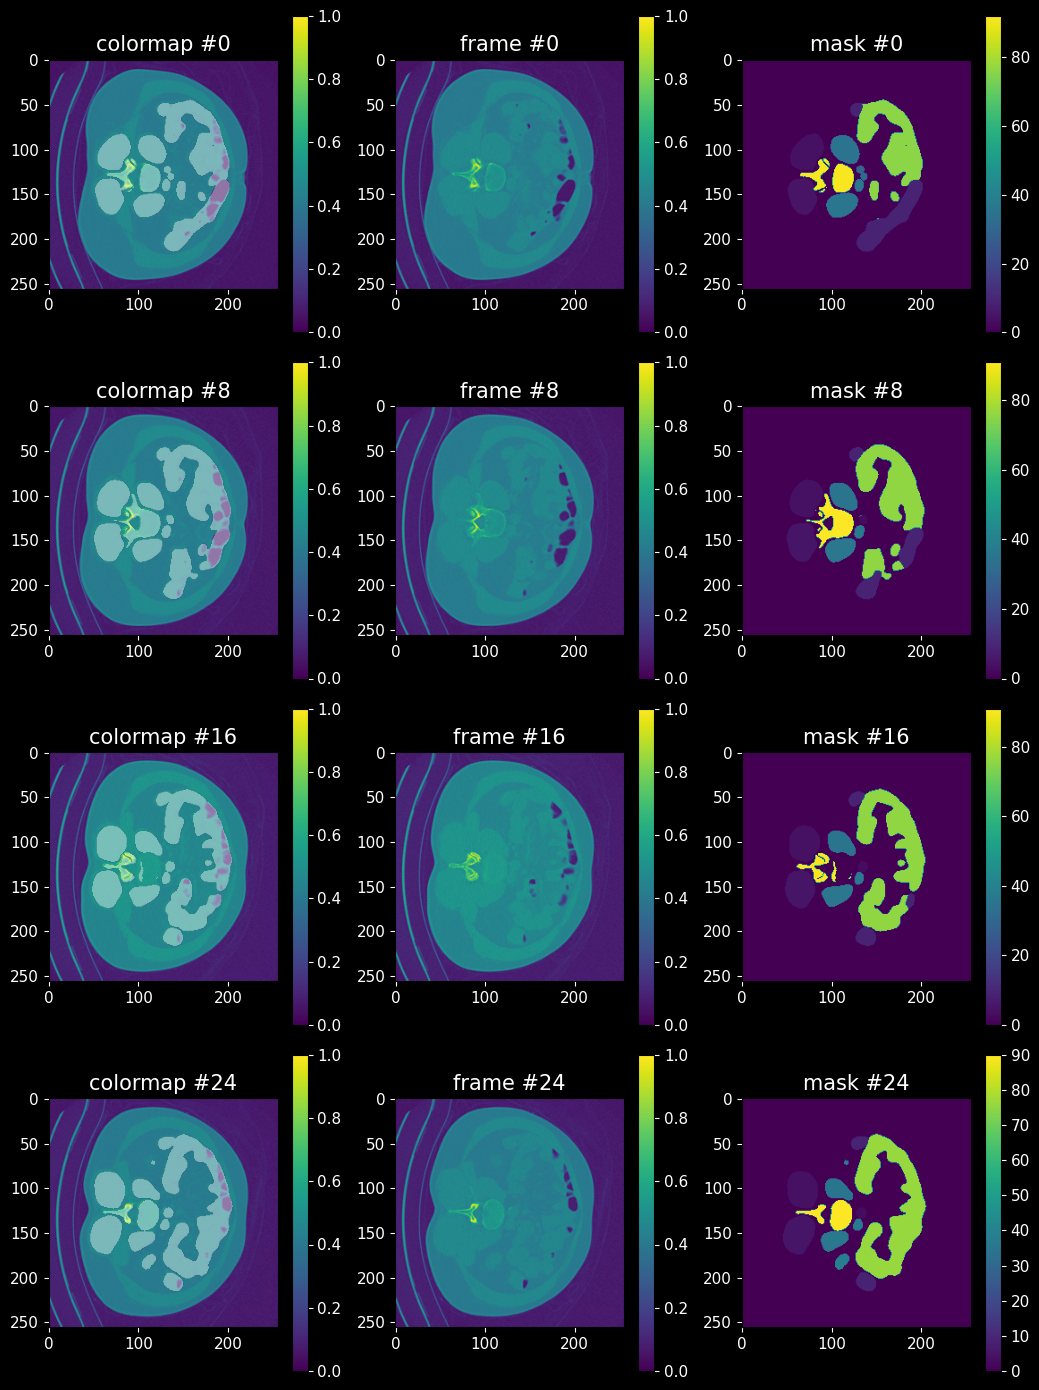

Input shape : (256, 256, 32, 1) - output shape : (256, 256, 32, 105)


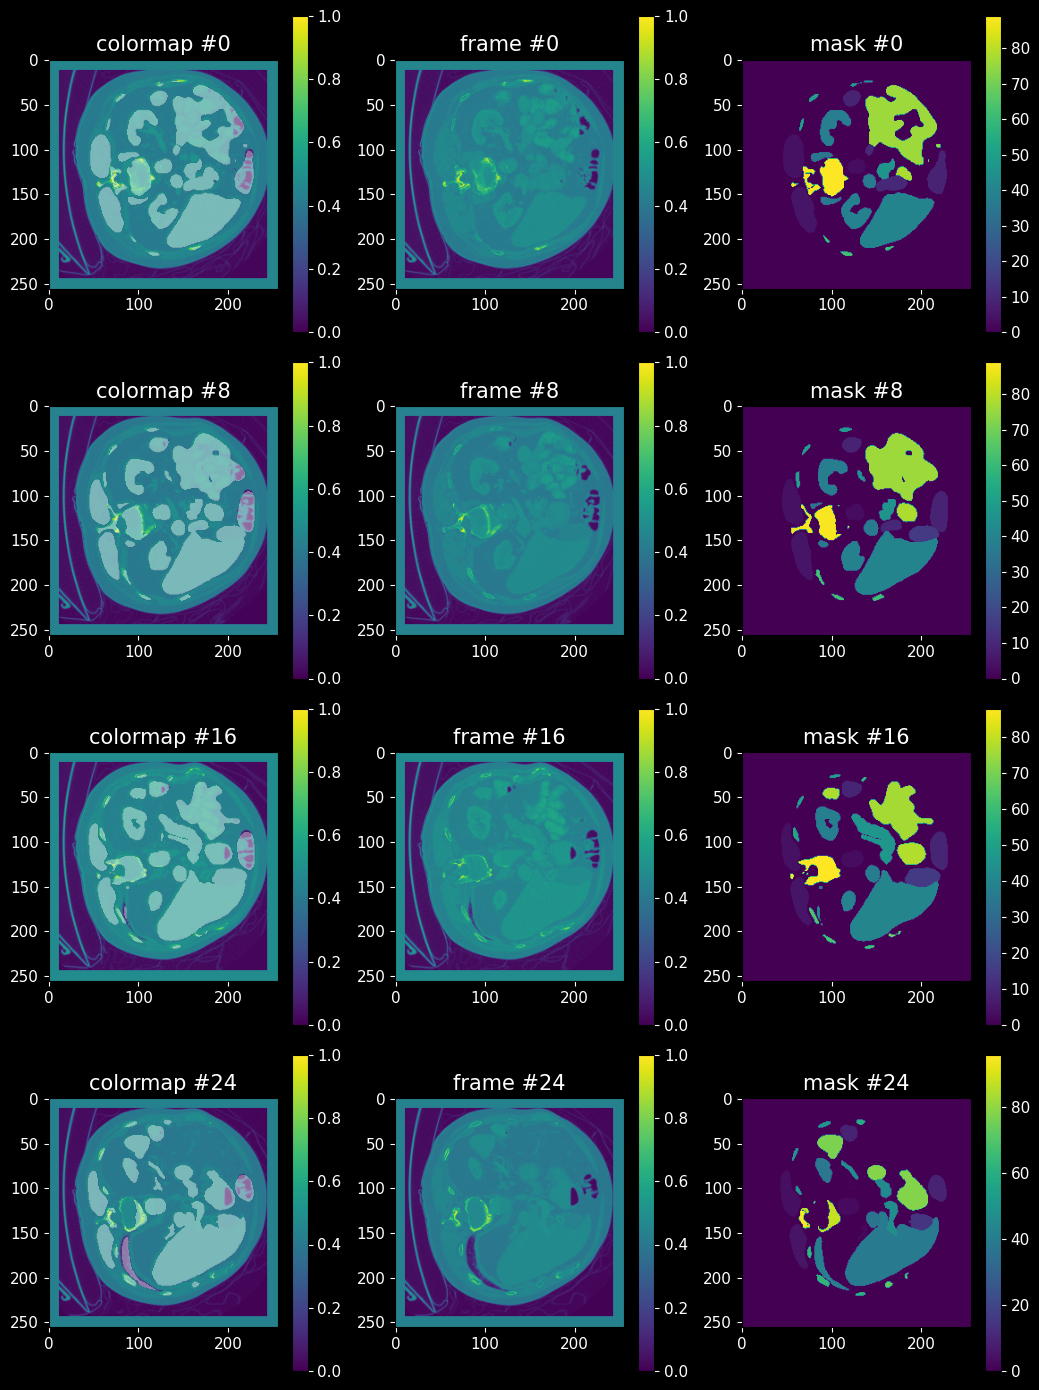

Input shape : (256, 256, 32, 1) - output shape : (256, 256, 32, 105)


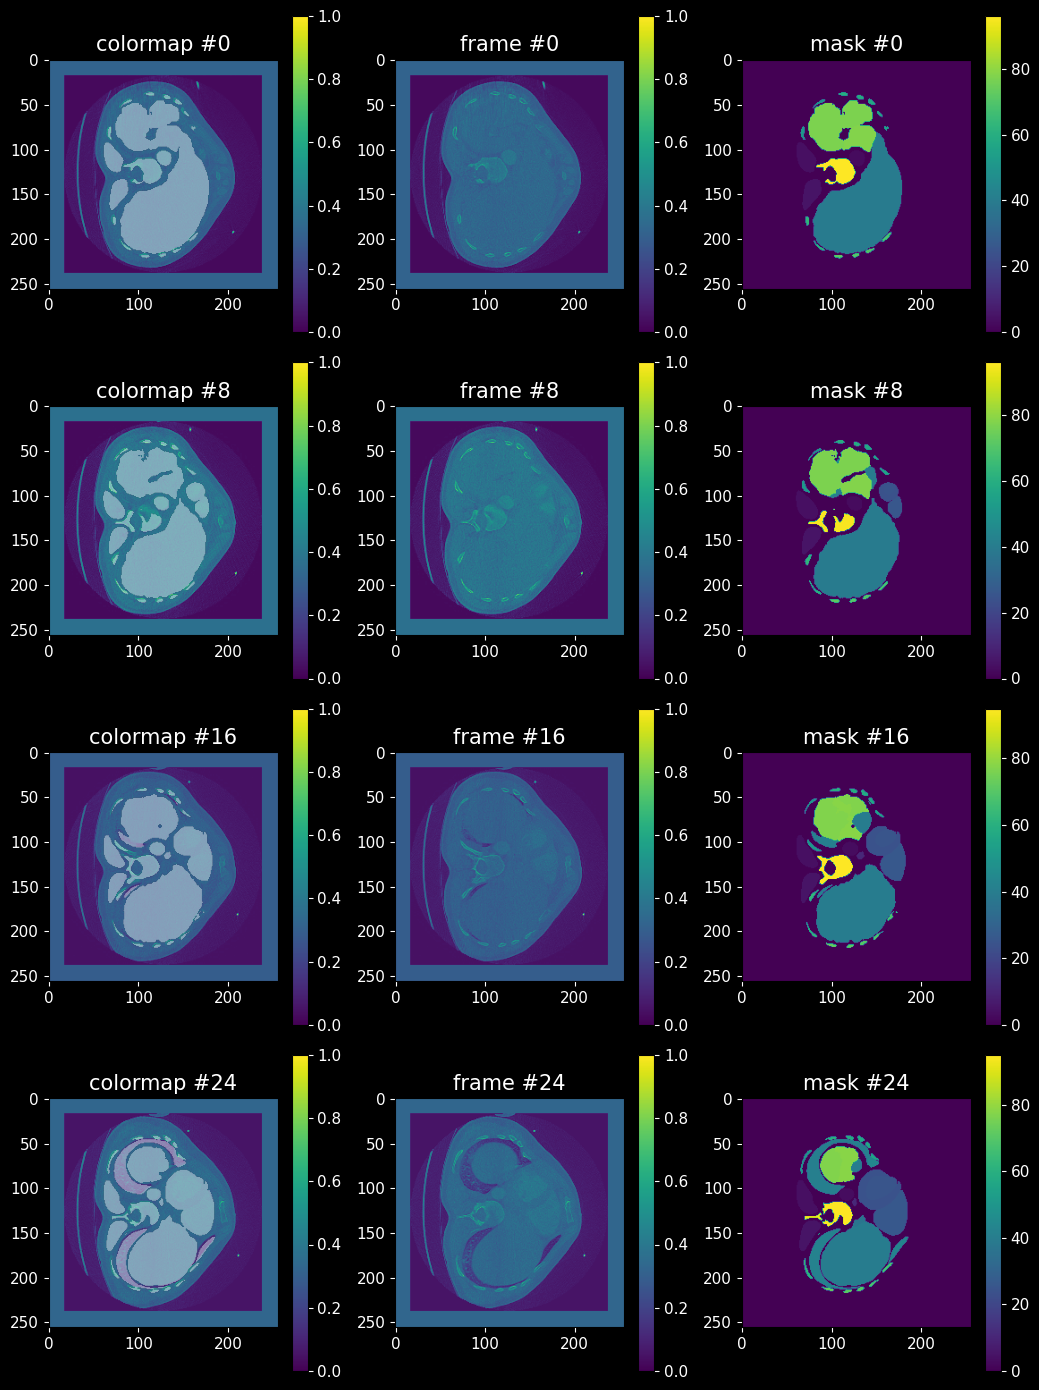

Input shape : (256, 256, 32, 1) - output shape : (256, 256, 32, 105)


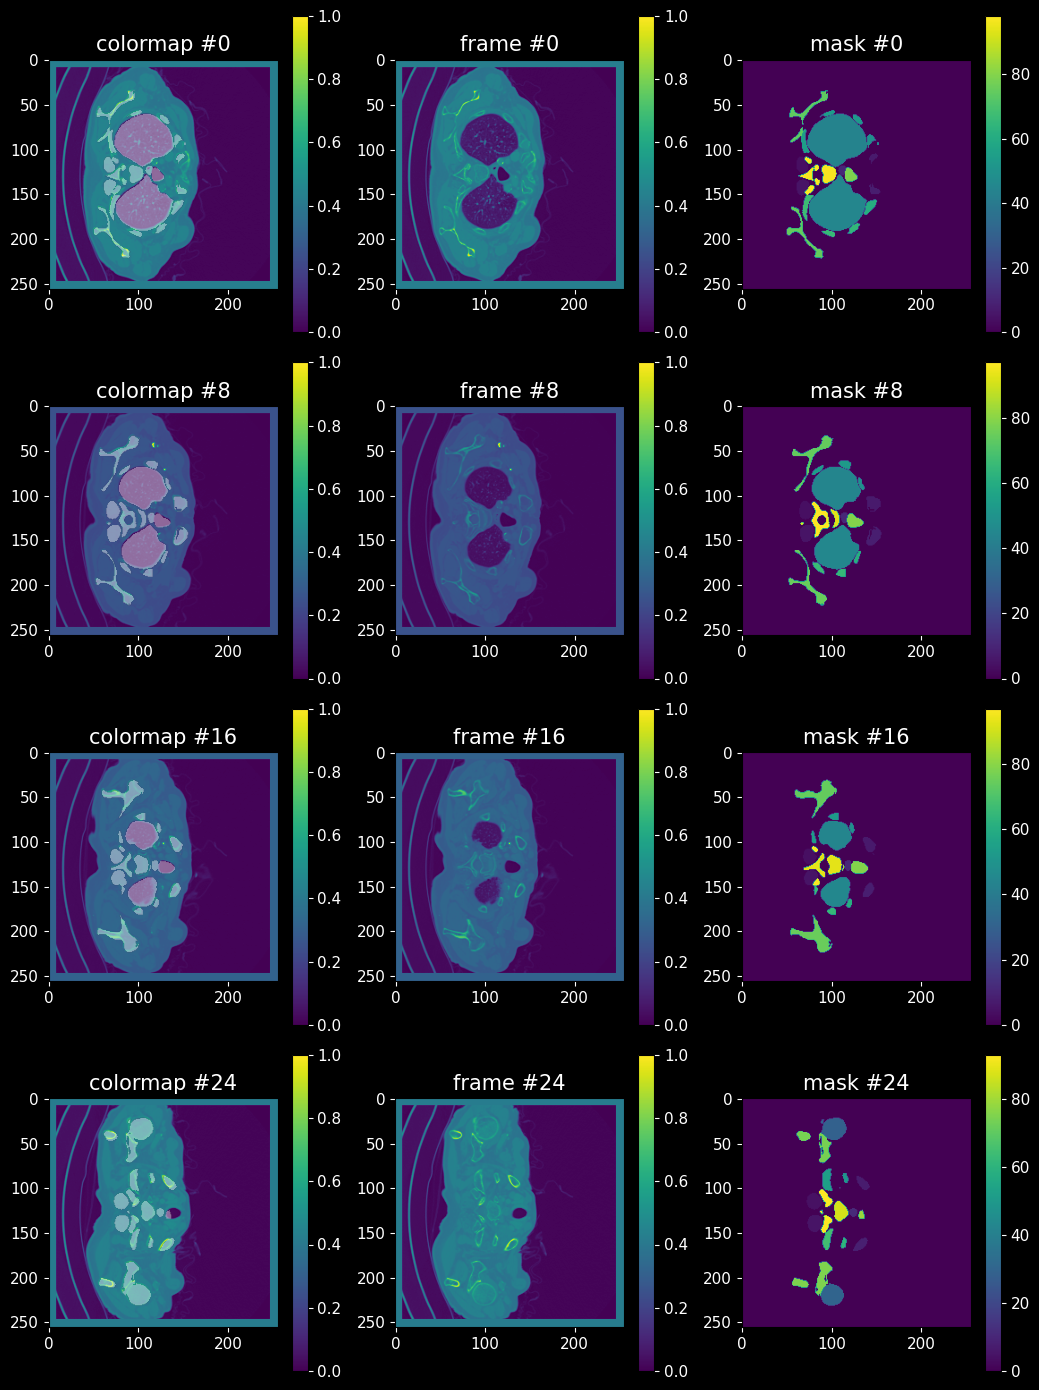

Input shape : (256, 256, 32, 1) - output shape : (256, 256, 32, 105)


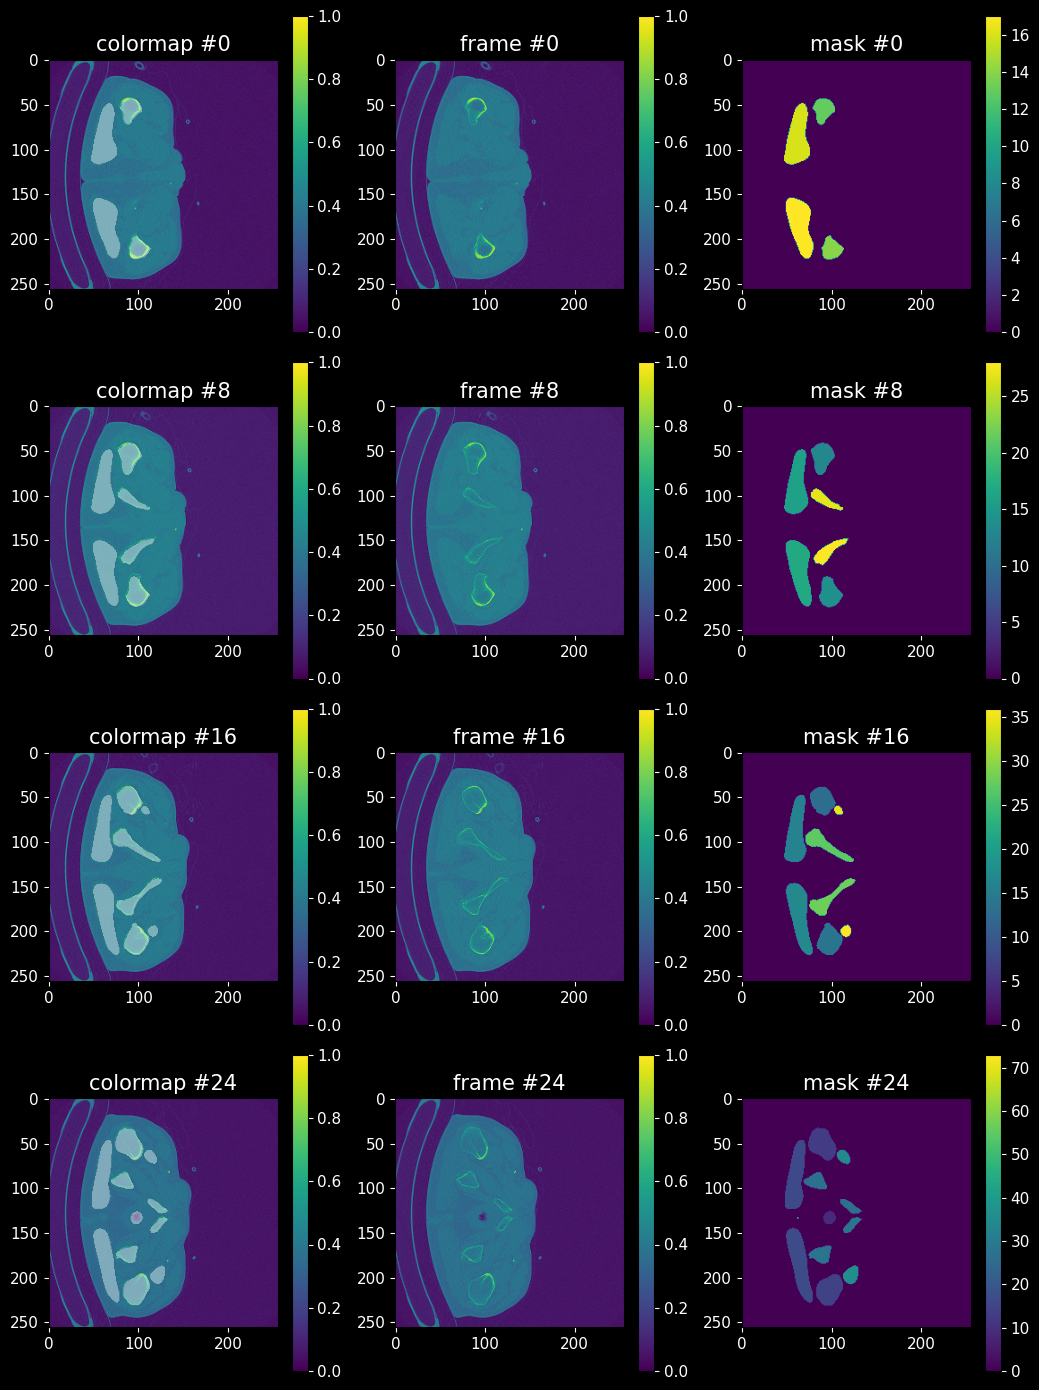

In [4]:
if 'highres' in model_name:
    max_size, max_frames = 512, 32
elif 'lowres' in model_name:
    max_size, max_frames = 128, 128
else:
    max_size, max_frames = 256 - 64, 32

if not isinstance(max_size, tuple):
    max_size = (max_size, max_size)

model.max_frames = max_frames
model.max_size   = max_size
model.pad_value  = 0.
print(model.max_size, model.max_frames)
config = model.get_dataset_config(is_validation = False, batch_size = 0, shuffle_size = 0)

set_level('debug', 'datasets')

ds = prepare_dataset(train.iloc[:5], ** config)

set_level('info', 'datasets')

for inp, out in ds:
    print('Input shape : {} - output shape : {}'.format(inp.shape, out.shape))
    plot_mask(inp[..., 0], out, n = 4)
    
    

### Test processing functions

In [ ]:
from tqdm import tqdm

n = 5
model.max_frames = 32
model.max_size   = (512, 512, 32)

for _, row in train.sample(n, random_state = 0).iterrows():
    inp, _ = model.get_input(row, False)
    print('Input shape : {} - {}'.format(inp.shape, inp.dtype))
    print("Original   : {} - {}".format(tf.reduce_min(inp), tf.reduce_max(inp)))
    inp = model.normalize_image(inp)
    print("Normalized : {} - {}".format(tf.reduce_min(inp), tf.reduce_max(inp)))
    inp = model.augment_input(inp)
    print("Augmented  : {} - {}".format(tf.reduce_min(inp), tf.reduce_max(inp)))


for _, row in train.sample(n, random_state = 0).iterrows():
    out = model.get_output_fn(row['segmentation'], row['label'])
    print('Output shape : {} - {} - type : {}'.format(out.shape, out.dtype, out.__class__.__name__))

for _, row in tqdm(train.sample(n, random_state = 0).iterrows()):
    inp, out = model.encode_data(row)
    print('Input shape : {} - output shape : {}'.format(inp.shape, out.shape))

Input shape : (261, 261, 273, 1) - <dtype: 'float32'>
Original   : -1213.0 - 3451.0
tf.Tensor(-1024.0, shape=(), dtype=float32)
Normalized : -1.4299732446670532 - 8.110487937927246
Augmented  : -1.4299732446670532 - 8.110487937927246
Input shape : (261, 261, 231, 1) - <dtype: 'float32'>
Original   : -1301.0 - 3439.0
tf.Tensor(-1024.0, shape=(), dtype=float32)
Normalized : -1.6102129220962524 - 8.069013595581055
Augmented  : -1.6102129220962524 - 8.069013595581055
Input shape : (262, 262, 285, 1) - <dtype: 'float32'>
Original   : -3468.0 - 3040.0
tf.Tensor(-3024.0, shape=(), dtype=float32)
Normalized : -2.167729139328003 - 3.560866355895996
Augmented  : -2.273104429244995 - 3.577291250228882
Input shape : (236, 236, 100, 1) - <dtype: 'float32'>
Original   : -3666.0 - 3539.0
tf.Tensor(-3024.0, shape=(), dtype=float32)
Normalized : -2.3022499084472656 - 4.143701076507568
Augmented  : -2.3022499084472656 - 4.143701076507568
Input shape : (232, 232, 96, 1) - <dtype: 'float32'>
Original   : 

0it [00:00, ?it/s]

[261 261 273 1] [1024 1024 64 1] [-763 -763 209 0] [(381, 382), (381, 382), (0, 0)] 0.0
0 0 138


In [5]:
from loggers import set_level

model.max_frames = 1
model.max_size   = (256, 256)

set_level('debug', 'datasets')

config = model.get_dataset_config(is_validation = True, batch_size = 0, cache = False, prefetch = False, shuffle_size = 0)

ds_train = prepare_dataset(train, ** config)

set_level('info', 'datasets')

for i, (inp, out) in enumerate(ds_train):
    print('Batch #{} : input shape = {} - output shape = {}'.format(i, inp.shape, out.shape))
    tf.sparse.to_dense(out)


Original dataset : <TensorSliceDataset element_spec={'subject_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'thickness': TensorSpec(shape=(), dtype=tf.int32, name=None), 'images': TensorSpec(shape=(), dtype=tf.string, name=None), 'segmentation': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(104,), dtype=tf.string, name=None)}>
- Dataset after encoding : <ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), SparseTensorSpec(TensorShape([None, None, None, None]), tf.uint8))>
Batch #0 : input shape = (256, 256, 1, 1) - output shape = (256, 256, 1, 105)
Batch #1 : input shape = (256, 256, 1, 1) - output shape = (256, 256, 1, 105)
Batch #2 : input shape = (256, 256, 1, 1) - output shape = (256, 256, 1, 105)
Batch #3 : input shape = (256, 256, 1, 1) - output shape = (256, 256, 1, 105)
Batch #4 : input shape = (256, 256, 1, 1) - output shape = (256, 256, 1, 105)
Batch #5 : input shape = (256, 256, 1, 1) 

In [ ]:
print(model.voxel_dims)

img, vox_dims = load_medical_image(train.loc[0, 'images'], target_voxel_dims = model.voxel_dims)
print(img.shape)

inp = model.get_input(train.loc[0], reshape = False)
print(inp.shape)

### Configure `learning-rate scheduler`

This cell allows you to play with `learning_rate scheduler`'s parameters to get the one you want !

In [ ]:
lr = model.model_optimizer.learning_rate
lr.factor = 1024.
lr.warmup_steps = 1024
lr.plot(512 * 15)